In [ ]:
#!pip install pandasql

In [2]:
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('action.csv')

In [266]:
df = df.loc[df["view"] != 'SurveyViewController']
df.shape

(101855, 12)

In [187]:
df

,id,secCode,view,action,detail,transactions,url,articleId,movie,promoCode,isSubscribed,timestamp
0,149,7A6AA717-5AB0-4B15-B638-0EA2D3E8FF21,DashboardViewController,viewWillAppear,none,,,,,,Y,2020-03-20 14:50:51
1,150,7A6AA717-5AB0-4B15-B638-0EA2D3E8FF21,ZoneChangesViewController,viewWillAppear,none,,,,,,Y,2020-03-20 14:51:06
2,151,7A6AA717-5AB0-4B15-B638-0EA2D3E8FF21,ScorecardViewController,viewWillAppear,none,,,,,,Y,2020-03-20 15:45:32
3,152,39B81396-CC9E-4358-B44D-7686817A72A5,DashboardViewController,viewWillAppear,none,,,,,,N,2020-03-21 11:44:21
4,153,39B81396-CC9E-4358-B44D-7686817A72A5,GuideViewController,guideViewWillAppear,none,,,,,,N,2020-03-21 11:44:21
...,...,...,...,...,...,...,...,...,...,...,...,...
102318,109741,0F749FF2-A962-4816-8890-5A544A77B95C,DashboardViewController,viewWillAppear,none,,,,,,N,2021-08-28 10:42:04
102319,109742,D89959A5-73B0-4C58-A37F-17336F5A8A7A,DashboardViewController,viewWillAppear,none,,,,,,N,2021-08-29 13:57:24
102320,109744,8199DA9E-4D72-441F-BF0E-187131AB68C4,DashboardViewController,viewWillAppear,none,,,,,,Y,2021-08-29 10:07:10
102321,109745,62870A81-E836-4068-92A5-1B654F16F5B1,DashboardViewController,viewWillAppear,none,,,,,,Y,2021-08-29 11:52:43


# Dataframe Derived

In [4]:
#real datafram
q = """
    with t1 as (
            select 
                *
                , row_number() over (PARTITION by secCode order by timestamp asc) activity_order
                , lead(timestamp) over (PARTITION by secCode order by timestamp asc)  lead_ts
            from df
    ),
    lastest as (
            select t.*
                from (
                    select
                        secCode
                        , isSubscribed  as lastSubscrib
                        , row_number() over (PARTITION by secCode order by timestamp desc) last_act
                    from df
                ) t
            where t.last_act = 1 
    ),    
    t2 as (
            select 
                t1.*
                , lastSubscrib
                , last_act
                , Round((JULIANDAY(lead_ts) - JULIANDAY(t1.timestamp)) * 86400) As Sec_length
            from t1 join lastest
            on lastest.secCode = t1.secCode
            
    )
    
    select 
        *
        , case 
            when sec_length <= 0 then 0
            when sec_length > 0 and sec_length <= 60 then 1
            when sec_length > 60 and sec_length <= 120 then 2
            when sec_length > 120 and sec_length <= 300 then 5
            when sec_length > 300 and sec_length <= 600 then 10
            when sec_length > 600 and sec_length <= 900 then 15
            when sec_length > 900 and sec_length <= 1200 then 20
            when sec_length > 1200 and sec_length <= 1500 then 25
            when sec_length > 1500 and sec_length <= 1800 then 30
            when sec_length > 1800 and sec_length <= 3600 then 60
            when sec_length > 3600 and sec_length <= 4500 then 75
            when sec_length > 4500 and sec_length <= 5400 then 90
            else 120
        end as time_spent
    from t2

 """
#sqldf(q)

In [5]:
new_df = sqldf(q)
new_df.head(5)

,id,secCode,view,action,detail,transactions,url,articleId,movie,promoCode,isSubscribed,timestamp,activity_order,lead_ts,lastSubscrib,last_act,Sec_length,time_spent
0,57667,0017241D-C63A-4248-9A8F-148AA30487BE,DashboardViewController,viewWillAppear,none,,,,,,N,2020-12-30 12:20:28,1,2020-12-30 12:20:29,N,1,1.0,1
1,57668,0017241D-C63A-4248-9A8F-148AA30487BE,GuideViewController,guideViewWillAppear,none,,,,,,N,2020-12-30 12:20:29,2,2020-12-30 12:20:32,N,1,3.0,1
2,57669,0017241D-C63A-4248-9A8F-148AA30487BE,GuideScorecardViewController,guideViewWillAppear,none,,,,,,N,2020-12-30 12:20:32,3,2020-12-30 12:20:35,N,1,3.0,1
3,57670,0017241D-C63A-4248-9A8F-148AA30487BE,GuideSDFViewController,guideViewWillAppear,none,,,,,,N,2020-12-30 12:20:35,4,2020-12-30 12:20:38,N,1,3.0,1
4,57671,0017241D-C63A-4248-9A8F-148AA30487BE,GuideZoneChangesViewController,guideViewWillAppear,none,,,,,,N,2020-12-30 12:20:38,5,2020-12-30 12:20:39,N,1,1.0,1


In [8]:
new_df.to_csv('new_df.csv')

In [ ]:
user_view.to_csv('user_view.csv')

In [211]:
#average account age is

sqldf("""
SELECT 
    avg(ts_diff) avg_acct_age
FROM (
    SELECT 
        secCode
        , (max(timestamp)) - min(timestamp) ts_diff 
    from new_df
    group by 1
)
""")

,avg_acct_age
0,0.086044


# Total count of view uses 

In [11]:
#Number of clicks by view

q  = """
    select 
        view 
        , count(*)
    from new_df
    group by 1
    order by 2 desc
    
    """

sqldf(q)


view_count = sqldf(q)
view_count

,view,count(*)
0,DashboardViewController,35417
1,GuideViewController,8697
2,ScorecardViewController,8108
3,GuideScorecardViewController,4739
4,GuideEmailViewController,4599
5,InfoViewController,4385
6,GuideSDFViewController,4380
7,GuideZoneChangesViewController,4196
8,GuideTipsViewController,4083
9,GuidePushViewController,3855


In [49]:
view_count = sqldf(q)
view_count


view_count.to_csv('view_count.csv')


In [12]:
#number of feature views for unsubscribed viewers

q  = """
    select 
        view 
        , count(*)
    from new_df
    where lastSubscrib != 'Y'
    group by 1
    order by 2 desc
    
    """

sqldf(q)


unsubscribed_view_count = sqldf(q)
unsubscribed_view_count

,view,count(*)
0,DashboardViewController,19819
1,GuideViewController,7099
2,GuideScorecardViewController,3868
3,GuideEmailViewController,3749
4,GuideSDFViewController,3580
5,GuideZoneChangesViewController,3433
6,GuideTipsViewController,3332
7,GuidePushViewController,3140
8,InfoViewController,1648
9,SubscriptionViewController,1546


In [13]:
#features views for subscribed viewers

q  = """
    select 
         view 
        , count(*)
    from new_df
    where lastSubscrib = 'Y'
    group by 1
    order by 2 desc
    
    
    """

sqldf(q)


Subscribed_view_count = sqldf(q)
Subscribed_view_count

,view,count(*)
0,DashboardViewController,15598
1,ScorecardViewController,6918
2,InfoViewController,2737
3,TickerViewController,2417
4,ZoneChangesViewController,2188
5,GuideViewController,1598
6,TipViewController,1544
7,SubscriptionViewController,1522
8,GuideScorecardViewController,871
9,GuideEmailViewController,850


# SecCode by Count of individual view

In [19]:
q = """
    with tab as 
            (
            select 
                secCode
                , sum(case when view = 'DashboardViewController' then 1 else 0 
                    end) as DashboardView 
                , sum(case when view = 'BestPracticesViewController' then 1 else 0 
                    end) as BestPracticesView
                , sum(case when view = 'NewsWebViewController' then 1 else 0 
                    end) as NewsWebView
                , sum(case when view = 'TipsViewController' then 1 else 0 
                    end) as TipsView
                , sum(case when view = 'ChartsViewController' then 1 else 0 
                    end) as ChartsView       
                , sum(case when view = 'IPadContainerViewController' then 1 else 0 
                    end) as IPadContainerView  
                , sum(case when view = 'GuideViewController' then 1 else 0 
                    end) as GuideView
                , sum(case when view = 'GuideScorecardViewController' then 1 else 0 
                    end) as GuideScorecardView
                , sum(case when view = 'GuideSDFViewController' then 1 else 0 
                    end) as GuideSDFView
                , sum(case when view = 'GuideZoneChangesViewController' then 1 else 0 
                    end) as GuideZoneChangesView
                , sum(case when view = 'GuideViewController' then 1 else 0 
                    end) as GuideView
                , sum(case when view = 'GuideTipsViewController' then 1 else 0 
                    end) as GuideTipsView
                , sum(case when view = 'GuideEmailViewController' then 1 else 0 
                    end) as GuideEmailView
                , sum(case when view = 'GuidePushViewController' then 1 else 0 
                    end) as GuidePushView
                , sum(case when view = 'InfoViewController' then 1 else 0 
                    end) as InfoView
                , sum(case when view = 'ScorecardViewController' then 1 else 0 
                    end) as ScorecardView
                , sum(case when view = 'NewsViewController' then 1 else 0 
                    end) as InfoView
                , sum(case when view = 'TickerViewController' then 1 else 0 
                    end) as TickerView
                , sum(case when view = 'CouldaViewController' then 1 else 0 
                    end) as CouldaView
                , sum(case when view = 'ZoneChangesViewController' then 1 else 0 
                    end) as ZoneChangesView
                , sum(case when view = 'CouldaViewController' then 1 else 0 
                    end) as CouldaView
                , sum(case when view = 'TipViewController' then 1 else 0 
                    end) as TipView
                , sum(case when view = 'NewsAddViewController' then 1 else 0 
                    end) as NewsAddView
                , sum(case when view = 'SettingsViewController' then 1 else 0 
                    end) as SettingsView
                , sum(case when view = 'IPadContainerViewController' then 1 else 0 
                    end) as IPadContainerView                
            from new_df
            group by 1
            )
        
    select 
        *
    from tab
    order by 2 desc
    
    """
secCode_individual_view_count = sqldf(q)
secCode_individual_view_count.head(5)

,secCode,DashboardView,BestPracticesView,NewsWebView,TipsView,ChartsView,IPadContainerView,GuideView,GuideScorecardView,GuideSDFView,...,ScorecardView,InfoView:1,TickerView,CouldaView,ZoneChangesView,CouldaView:1,TipView,NewsAddView,SettingsView,IPadContainerView:1
0,62870A81-E836-4068-92A5-1B654F16F5B1,2760,1,0,202,15,0,20,14,14,...,1870,4,28,67,50,67,290,0,6,0
1,0D034B75-58D4-4197-8F7B-6CC1F07A5661,984,6,8,9,169,0,88,66,68,...,579,98,102,49,74,49,46,57,65,0
2,AB05BBE1-F3A3-43E3-B730-9CBDD069B048,320,0,2,5,9,0,30,18,14,...,226,6,12,11,14,11,10,3,18,0
3,FA759AA5-2CCA-4634-A34C-279AAE3ECBDD,287,2,0,0,4,0,17,8,4,...,173,3,29,1,66,1,8,3,0,0
4,8124FAAA-5A53-45F3-9847-5525F4FA26DA,260,0,2,1,9,0,15,7,6,...,40,14,126,6,36,6,2,11,14,0


In [106]:
# total users of account
sqldf("""
select count(distinct secCode) as Total_users
from new_df""")

,Total_users
0,3812


In [108]:
#Total Subscribed user

sqldf("""
select count(distinct secCode) as subscribed_users
from new_df
where lastSubscrib = 'Y'
""")

,subscribed_users
0,312


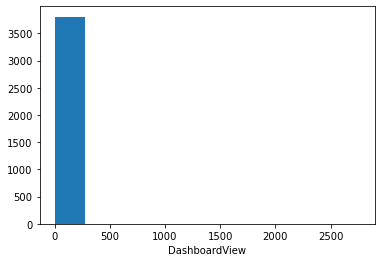

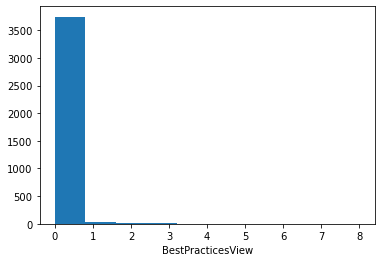

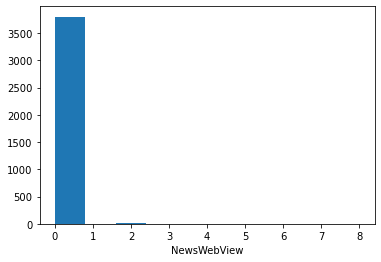

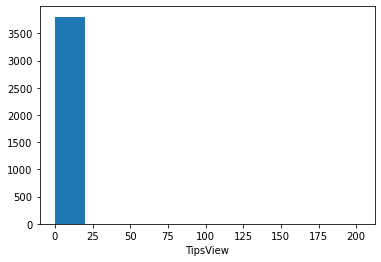

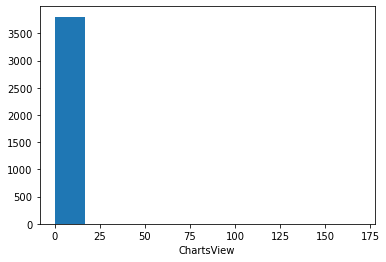

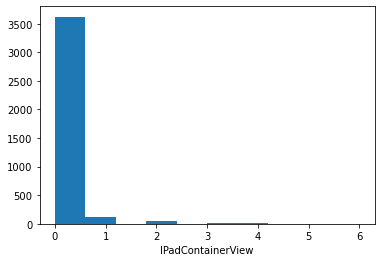

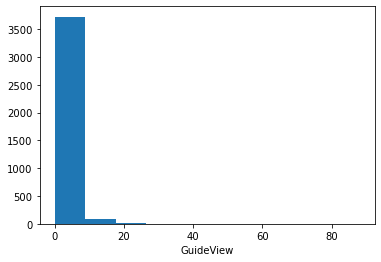

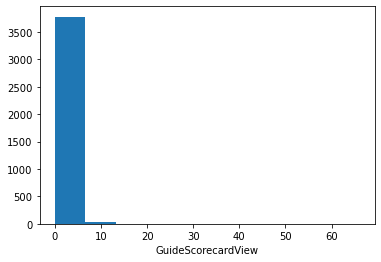

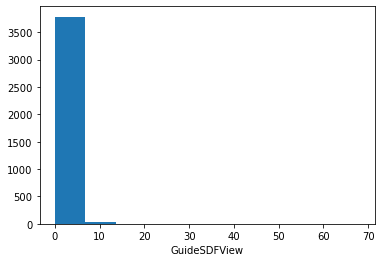

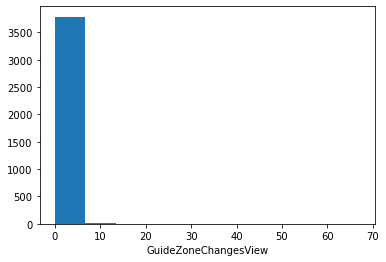

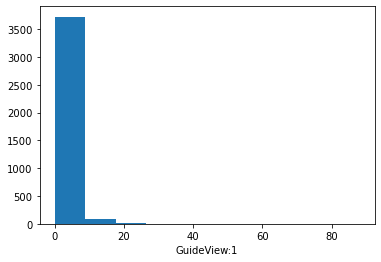

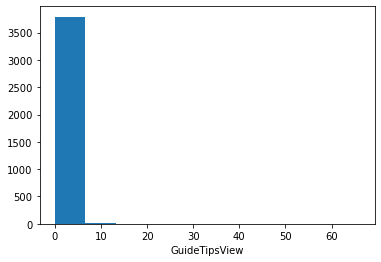

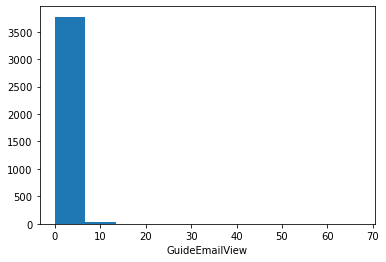

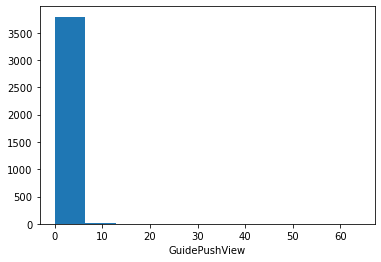

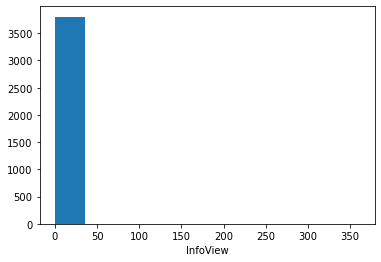

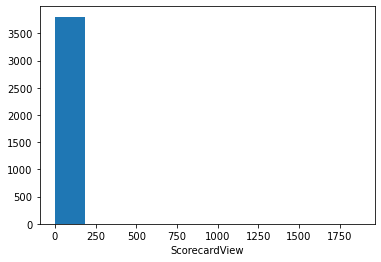

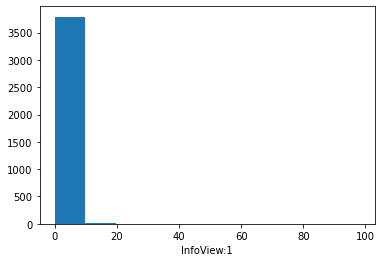

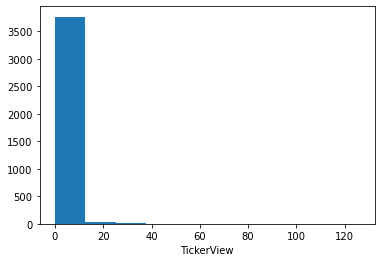

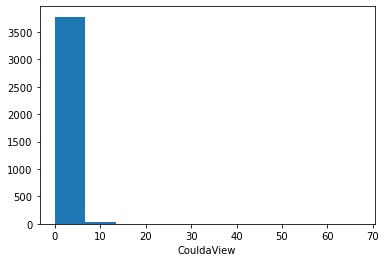

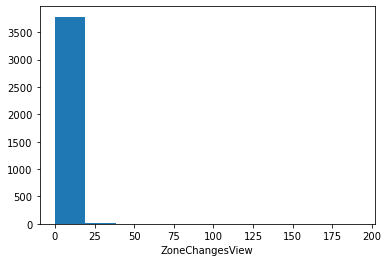

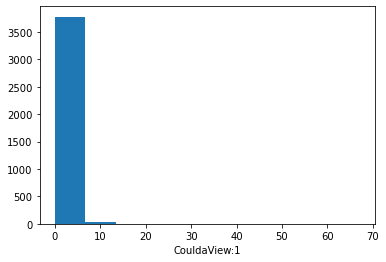

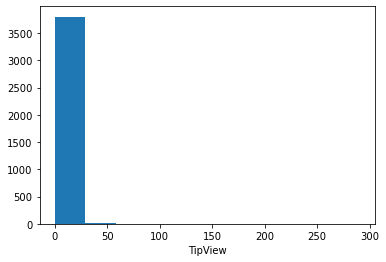

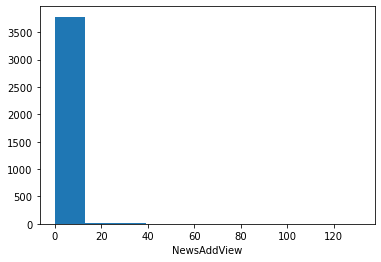

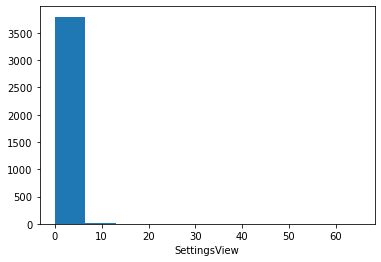

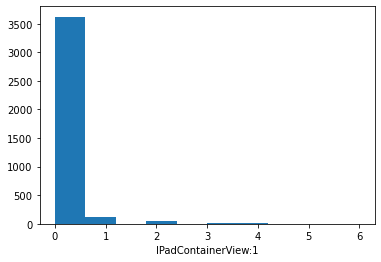

In [20]:
X = secCode_individual_view_count.drop('secCode', axis= 1)

for i in X:
    plt.figure(i)
    plt.hist(X[i])
    plt.xlabel(i)
    #plt.savefig('sub30 {0}.jpg'.format(i))
    #plt.close()
    plt.show()

In [21]:
for col in X:
    print( col , ':', X[col].std(), "mean", ':', X[col].mean())

DashboardView : 50.60681983788036 mean : 9.290923399790136
BestPracticesView : 0.37234780589011396 mean : 0.041710388247639035
NewsWebView : 0.16184344203300607 mean : 0.006820566631689402
TipsView : 3.5435960079082203 mean : 0.21117523609653724
ChartsView : 3.29341900920044 mean : 0.21091290661070305
IPadContainerView : 0.4398993805285476 mean : 0.08342077649527807
GuideView : 2.6059784552265124 mean : 2.281479538300105
GuideScorecardView : 1.6185402996098668 mean : 1.2431794333683106
GuideSDFView : 1.570136400418012 mean : 1.14900314795383
GuideZoneChangesView : 1.5281250221328793 mean : 1.1007345225603358
GuideView:1 : 2.6059784552265124 mean : 2.281479538300105
GuideTipsView : 1.4985109604069347 mean : 1.0710912906610703
GuideEmailView : 1.7201570388886545 mean : 1.2064533053515216
GuidePushView : 1.4478166002995578 mean : 1.011280167890871
InfoView : 6.957019708761368 mean : 1.150314795383001
ScorecardView : 34.29193262756997 mean : 2.1269674711437565
InfoView:1 : 2.22859889660782

# Average views per secCode

In [22]:
q = """
    with tab as 
            (
            select 
                secCode
                , avg(case when view = 'DashboardViewController' then 1 else 0 
                    end) as DashboardView 
                , avg(case when view = 'BestPracticesViewController' then 1 else 0 
                    end) as BestPracticesView
                , avg(case when view = 'NewsWebViewController' then 1 else 0 
                    end) as NewsWebView
                , avg(case when view = 'TipsViewController' then 1 else 0 
                    end) as TipsView
                , avg(case when view = 'ChartsViewController' then 1 else 0 
                    end) as ChartsView       
                , avg(case when view = 'IPadContainerViewController' then 1 else 0 
                    end) as IPadContainerView  
                , avg(case when view = 'GuideViewController' then 1 else 0 
                    end) as GuideView
                , avg(case when view = 'GuideScorecardViewController' then 1 else 0 
                    end) as GuideScorecardView
                , avg(case when view = 'GuideSDFViewController' then 1 else 0 
                    end) as GuideSDFView
                , avg(case when view = 'GuideZoneChangesViewController' then 1 else 0 
                    end) as GuideZoneChangesView
                , avg(case when view = 'GuideViewController' then 1 else 0 
                    end) as GuideView
                , avg(case when view = 'GuideTipsViewController' then 1 else 0 
                    end) as GuideTipsView
                , avg(case when view = 'GuideEmailViewController' then 1 else 0 
                    end) as GuideEmailView
                , avg(case when view = 'GuidePushViewController' then 1 else 0 
                    end) as GuidePushView
                , avg(case when view = 'InfoViewController' then 1 else 0 
                    end) as InfoView
                , avg(case when view = 'ScorecardViewController' then 1 else 0 
                    end) as ScorecardView
                , avg(case when view = 'NewsViewController' then 1 else 0 
                    end) as InfoView
                , avg(case when view = 'TickerViewController' then 1 else 0 
                    end) as TickerView
                , avg(case when view = 'CouldaViewController' then 1 else 0 
                    end) as CouldaView
                , avg(case when view = 'ZoneChangesViewController' then 1 else 0 
                    end) as ZoneChangesView
                , avg(case when view = 'CouldaViewController' then 1 else 0 
                    end) as CouldaView
                , avg(case when view = 'TipViewController' then 1 else 0 
                    end) as TipView
                , avg(case when view = 'NewsAddViewController' then 1 else 0 
                    end) as NewsAddView
                , avg(case when view = 'SettingsViewController' then 1 else 0 
                    end) as SettingsView
                , avg(case when view = 'IPadContainerViewController' then 1 else 0 
                    end) as IPadContainerView                
            from new_df
            group by 1
            )
        
    select 
        *
    from tab
    order by 2 desc
    
    """
Average_views_per_secCode = sqldf(q)
Average_views_per_secCode.head(5)

,secCode,DashboardView,BestPracticesView,NewsWebView,TipsView,ChartsView,IPadContainerView,GuideView,GuideScorecardView,GuideSDFView,...,ScorecardView,InfoView:1,TickerView,CouldaView,ZoneChangesView,CouldaView:1,TipView,NewsAddView,SettingsView,IPadContainerView:1
0,0076412A-A32E-4BAE-B9F5-4980A9C716F7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00B697C3-8B60-4522-B361-69F645FA3162,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,01207A56-1F2F-40F8-972B-A7323E51BF0F,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,05130CCD-FAF4-4F08-B39F-217475465942,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,06A87D66-CA32-4CE1-B613-B681BE15FF5F,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
#USing just the dashboard view, we can see the standard deviation is over two standard deviations away from the means


18.581846799580273

In [23]:
dashboard = sqldf("""

            select 
                count(distinct secCode)
                , (count(distinct secCode)*1.0)/(select count(distinct secCode) from new_df)
            from secCode_individual_view_count
            where DashboardView > 110
            """)
dashboard

,count(distinct secCode),(count(distinct secCode)*1.0)/(select count(distinct secCode) from new_df)
0,21,0.005509


In [44]:
dashboard_secCode_outlier = sqldf("""
            select siv.secCode 
            from secCode_individual_view_count siv
            where siv.secCode in
            (select 
                distinct secCode as secCode
            from secCode_individual_view_count 
            where DashboardView > 110) 
            """)
dashboard_secCode_outlier

,secCode
0,62870A81-E836-4068-92A5-1B654F16F5B1
1,0D034B75-58D4-4197-8F7B-6CC1F07A5661
2,AB05BBE1-F3A3-43E3-B730-9CBDD069B048
3,FA759AA5-2CCA-4634-A34C-279AAE3ECBDD
4,8124FAAA-5A53-45F3-9847-5525F4FA26DA
5,D9C9EE89-5725-4C3E-B196-7E1B3C05BCAE
6,F7EDDD3C-0B44-4CA0-85F0-5A35D739143C
7,C5DBA55E-049D-4B39-AF7A-40293942DBF6
8,F6CBF0DB-E73B-4F89-866E-F5D65F7CB2E2
9,3F946033-D8C5-4A7A-9E0E-C304650E9A85


In [56]:
 2.281479538300105 -(2.6059784552265124*2) 

-2.93047737215292

In [58]:
GuideView = sqldf("""
            select 
                count(distinct secCode)
                , (count(distinct secCode)*1.0)/(select count(distinct secCode) from new_df) as Percent_Guide
            from secCode_individual_view_count
            where GuideView > 8
            or guideview < -3
            """)
GuideView

,count(distinct secCode),Percent_Guide
0,90,0.02361


In [24]:
GuideView_secCount_outlier = sqldf("""
            select  distinct secCode 
            from secCode_individual_view_count siv
            where siv.secCode in
            (select 
                distinct secCode as secCode
            from secCode_individual_view_count 
            where guideView > 8) 
            """)
GuideView_secCount_outlier

,secCode
0,62870A81-E836-4068-92A5-1B654F16F5B1
1,0D034B75-58D4-4197-8F7B-6CC1F07A5661
2,AB05BBE1-F3A3-43E3-B730-9CBDD069B048
3,FA759AA5-2CCA-4634-A34C-279AAE3ECBDD
4,8124FAAA-5A53-45F3-9847-5525F4FA26DA
...,...
85,C8646EBE-2459-450C-A561-81FCF8956B33
86,5912FBAB-5E8C-4D49-9634-E85A80924DF4
87,463F62E3-F925-480A-94C3-AACE5FEA293F
88,833807D5-E737-4E4A-AD76-FF1ADA019366


In [25]:
try1 = sqldf(
            """
            select * 
            from new_df
            where secCode = '62870A81-E836-4068-92A5-1B654F16F5B1'
            
            """
)

try1

,id,secCode,view,action,detail,transactions,url,articleId,movie,promoCode,isSubscribed,timestamp,activity_order,lead_ts,lastSubscrib,last_act,Sec_length,time_spent
0,265,62870A81-E836-4068-92A5-1B654F16F5B1,DashboardViewController,viewWillAppear,none,,,,,,Y,2020-03-23 04:28:43,1,2020-03-23 04:28:43,Y,1,0.0,0
1,266,62870A81-E836-4068-92A5-1B654F16F5B1,GuideViewController,guideViewWillAppear,none,,,,,,Y,2020-03-23 04:28:43,2,2020-03-23 04:28:46,Y,1,3.0,1
2,267,62870A81-E836-4068-92A5-1B654F16F5B1,GuideScorecardViewController,guideViewWillAppear,none,,,,,,Y,2020-03-23 04:28:46,3,2020-03-23 04:28:58,Y,1,12.0,1
3,268,62870A81-E836-4068-92A5-1B654F16F5B1,GuideSDFViewController,guideViewWillAppear,none,,,,,,Y,2020-03-23 04:28:58,4,2020-03-23 04:28:59,Y,1,1.0,1
4,269,62870A81-E836-4068-92A5-1B654F16F5B1,GuideZoneChangesViewController,guideViewWillAppear,none,,,,,,Y,2020-03-23 04:28:59,5,2020-03-23 04:29:10,Y,1,11.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5399,109710,62870A81-E836-4068-92A5-1B654F16F5B1,DashboardViewController,viewWillAppear,none,,,,,,Y,2021-08-28 12:16:55,5400,2021-08-28 18:22:45,Y,1,21950.0,120
5400,109723,62870A81-E836-4068-92A5-1B654F16F5B1,DashboardViewController,viewWillAppear,none,,,,,,Y,2021-08-28 18:22:45,5401,2021-08-28 18:22:49,Y,1,4.0,1
5401,109724,62870A81-E836-4068-92A5-1B654F16F5B1,ScorecardViewController,viewWillAppear,none,,,,,,Y,2021-08-28 18:22:49,5402,2021-08-28 19:58:02,Y,1,5713.0,120
5402,109727,62870A81-E836-4068-92A5-1B654F16F5B1,DashboardViewController,viewWillAppear,none,,,,,,Y,2021-08-28 19:58:02,5403,2021-08-29 11:52:43,Y,1,57281.0,120


In [75]:
q = """
    with t1 as (
            select  *
            from secCode_individual_view_count siv
            where siv.secCode in
            (select 
                distinct secCode as secCode
            from secCode_individual_view_count 
            where guideView < 8) 
    
    )
    select 
        *
    from t1
    order by 2 desc
    
    """


try1 = sqldf(q)
try1

,secCode,DashboardView,BestPracticesView,NewsWebView,TipsView,ChartsView,IPadContainerView,GuideView,GuideScorecardView,GuideSDFView,...,ScorecardView,InfoView:1,TickerView,CouldaView,ZoneChangesView,CouldaView:1,TipView,NewsAddView,SettingsView,IPadContainerView:1
0,D9C9EE89-5725-4C3E-B196-7E1B3C05BCAE,243,0,0,0,1,0,5,1,1,...,17,0,108,0,68,0,0,0,2,0
1,BF76277D-4689-454F-BADD-215FB14CAEE9,186,0,0,1,2,2,3,3,3,...,247,2,0,2,192,2,15,4,6,2
2,3EDEBB99-2C96-405A-9C07-D88C9F544BA8,160,2,0,5,22,0,7,2,2,...,68,4,57,3,18,3,11,6,10,0
3,8AC20863-FB96-41A9-8822-884E238085DD,129,0,0,0,2,0,7,5,4,...,71,0,7,0,8,0,3,0,0,0
4,0F749FF2-A962-4816-8890-5A544A77B95C,109,0,0,0,0,0,2,1,1,...,1,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3695,FCEB0B9F-7980-4414-84F8-A56882F52020,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3696,FD5DD76E-6DC5-4595-A135-920733BA61E2,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3697,FD989BB7-58AD-4691-9337-76AD315C07B5,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3698,FE17AA19-EB40-40B6-B124-DEE1E0EC414E,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


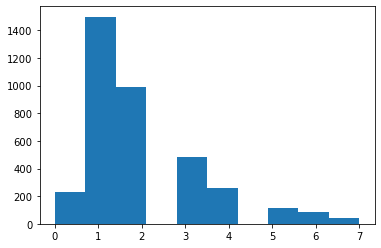

In [79]:
X = try1

plt.hist(X['GuideView'])
plt.show()

In [82]:
q = """
    with t1 as (
            select  *
            from secCode_individual_view_count siv
            where siv.secCode in
            (select 
                distinct secCode as secCode
            from secCode_individual_view_count 
            where DashboardView < 110) 
    
    )
    select 
        *
    from t1
    order by 2 desc
    
    """


try2 = sqldf(q)
try2

,secCode,DashboardView,BestPracticesView,NewsWebView,TipsView,ChartsView,IPadContainerView,GuideView,GuideScorecardView,GuideSDFView,...,ScorecardView,InfoView:1,TickerView,CouldaView,ZoneChangesView,CouldaView:1,TipView,NewsAddView,SettingsView,IPadContainerView:1
0,62870A81-E836-4068-92A5-1B654F16F5B1,2760,1,0,202,15,0,20,14,14,...,1870,4,28,67,50,67,290,0,6,0
1,0D034B75-58D4-4197-8F7B-6CC1F07A5661,984,6,8,9,169,0,88,66,68,...,579,98,102,49,74,49,46,57,65,0
2,AB05BBE1-F3A3-43E3-B730-9CBDD069B048,320,0,2,5,9,0,30,18,14,...,226,6,12,11,14,11,10,3,18,0
3,FA759AA5-2CCA-4634-A34C-279AAE3ECBDD,287,2,0,0,4,0,17,8,4,...,173,3,29,1,66,1,8,3,0,0
4,8124FAAA-5A53-45F3-9847-5525F4FA26DA,260,0,2,1,9,0,15,7,6,...,40,14,126,6,36,6,2,11,14,0
5,D9C9EE89-5725-4C3E-B196-7E1B3C05BCAE,243,0,0,0,1,0,5,1,1,...,17,0,108,0,68,0,0,0,2,0
6,F7EDDD3C-0B44-4CA0-85F0-5A35D739143C,240,0,0,2,7,0,13,4,3,...,163,12,94,15,37,15,9,30,5,0
7,C5DBA55E-049D-4B39-AF7A-40293942DBF6,233,0,0,0,0,0,9,5,4,...,5,4,106,0,22,0,4,22,1,0
8,F6CBF0DB-E73B-4F89-866E-F5D65F7CB2E2,232,0,0,5,7,0,21,6,6,...,23,3,7,4,5,4,10,8,0,0
9,3F946033-D8C5-4A7A-9E0E-C304650E9A85,225,0,0,8,1,0,8,5,4,...,2,14,22,5,19,5,22,13,0,0


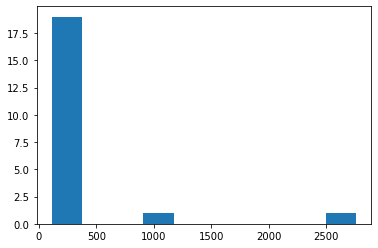

In [83]:
X = try2

plt.hist(X['DashboardView'])
plt.show()

In [ ]:
GuideZoneChangesView : 1.5281250221328793 mean : 1.1007345225603358

In [85]:
1.1007345225603358 + (2*1.5281250221328793)

4.156984566826094

In [86]:
q = """
    with t1 as (
            select  *
            from secCode_individual_view_count siv
            where siv.secCode in
            (select 
                distinct secCode as secCode
            from secCode_individual_view_count 
            where GuideZoneChangesView < 5) 
    
    )
    select 
        *
    from t1
    order by 2 desc
    
    """


try3 = sqldf(q)
try3

,secCode,DashboardView,BestPracticesView,NewsWebView,TipsView,ChartsView,IPadContainerView,GuideView,GuideScorecardView,GuideSDFView,...,ScorecardView,InfoView:1,TickerView,CouldaView,ZoneChangesView,CouldaView:1,TipView,NewsAddView,SettingsView,IPadContainerView:1
0,FA759AA5-2CCA-4634-A34C-279AAE3ECBDD,287,2,0,0,4,0,17,8,4,...,173,3,29,1,66,1,8,3,0,0
1,8124FAAA-5A53-45F3-9847-5525F4FA26DA,260,0,2,1,9,0,15,7,6,...,40,14,126,6,36,6,2,11,14,0
2,D9C9EE89-5725-4C3E-B196-7E1B3C05BCAE,243,0,0,0,1,0,5,1,1,...,17,0,108,0,68,0,0,0,2,0
3,F7EDDD3C-0B44-4CA0-85F0-5A35D739143C,240,0,0,2,7,0,13,4,3,...,163,12,94,15,37,15,9,30,5,0
4,C5DBA55E-049D-4B39-AF7A-40293942DBF6,233,0,0,0,0,0,9,5,4,...,5,4,106,0,22,0,4,22,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3748,FCEB0B9F-7980-4414-84F8-A56882F52020,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3749,FD5DD76E-6DC5-4595-A135-920733BA61E2,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3750,FD989BB7-58AD-4691-9337-76AD315C07B5,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3751,FE17AA19-EB40-40B6-B124-DEE1E0EC414E,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


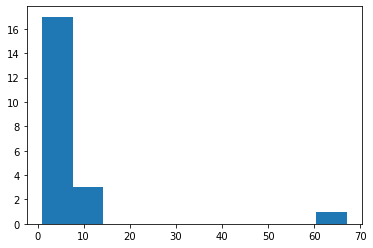

In [87]:
X = try2

plt.hist(X['GuideZoneChangesView'])
plt.show()

In [ ]:
GuideView = sqldf("""
            select 
                count(distinct secCode)
                , (count(distinct secCode)*1.0)/(select count(distinct secCode) from new_df) as Percent_Guide
            from secCode_individual_view_count
            where DashboardView  < 5
            """)
GuideView

# Subscribed secCode by individual views

In [26]:
subcribed_user_view_count = """
    with t1 as(
        select *
        from new_df
        where lastSubscrib = 'Y'
    ),
    t2 as 
            (
            select 
                secCode
                , sum(case when view = 'DashboardViewController' then 1 else 0 
                    end) as DashboardView 
                , sum(case when view = 'BestPracticesViewController' then 1 else 0 
                    end) as BestPracticesView
                , sum(case when view = 'NewsWebViewController' then 1 else 0 
                    end) as NewsWebView
                , sum(case when view = 'TipsViewController' then 1 else 0 
                    end) as TipsView
                , sum(case when view = 'ChartsViewController' then 1 else 0 
                    end) as ChartsView       
                , sum(case when view = 'IPadContainerViewController' then 1 else 0 
                    end) as IPadContainerView  
                , sum(case when view = 'GuideViewController' then 1 else 0 
                    end) as GuideView
                , sum(case when view = 'GuideScorecardViewController' then 1 else 0 
                    end) as GuideScorecardView
                , sum(case when view = 'GuideSDFViewController' then 1 else 0 
                    end) as GuideSDFView
                , sum(case when view = 'GuideZoneChangesViewController' then 1 else 0 
                    end) as GuideZoneChangesView
                , sum(case when view = 'GuideTipsViewController' then 1 else 0 
                    end) as GuideTipsView
                , sum(case when view = 'GuideEmailViewController' then 1 else 0 
                    end) as GuideEmailView
                , sum(case when view = 'GuidePushViewController' then 1 else 0 
                    end) as GuidePushView
                , sum(case when view = 'InfoViewController' then 1 else 0 
                    end) as InfoView
                , sum(case when view = 'ScorecardViewController' then 1 else 0 
                    end) as ScorecardView
                , sum(case when view = 'NewsViewController' then 1 else 0 
                    end) as InfoView
                , sum(case when view = 'TickerViewController' then 1 else 0 
                    end) as TickerView
                , sum(case when view = 'CouldaViewController' then 1 else 0 
                    end) as CouldaView
                , sum(case when view = 'ZoneChangesViewController' then 1 else 0 
                    end) as ZoneChangesView
                , sum(case when view = 'CouldaViewController' then 1 else 0 
                    end) as CouldaView
                , sum(case when view = 'TipViewController' then 1 else 0 
                    end) as TipView
                , sum(case when view = 'NewsAddViewController' then 1 else 0 
                    end) as NewsAddView
                , sum(case when view = 'SettingsViewController' then 1 else 0 
                    end) as SettingsView
                , sum(case when view = 'IPadContainerViewController' then 1 else 0 
                    end) as IPadContainerView                 
            from t1
            group by 1
            )
        
    select 
        *
    from t2
    order by 2 desc
    
    """

In [27]:
subscribed_users_by_view_count = sqldf(subcribed_user_view_count)
subscribed_users_by_view_count.head(5)

,secCode,DashboardView,BestPracticesView,NewsWebView,TipsView,ChartsView,IPadContainerView,GuideView,GuideScorecardView,GuideSDFView,...,ScorecardView,InfoView:1,TickerView,CouldaView,ZoneChangesView,CouldaView:1,TipView,NewsAddView,SettingsView,IPadContainerView:1
0,62870A81-E836-4068-92A5-1B654F16F5B1,2760,1,0,202,15,0,20,14,14,...,1870,4,28,67,50,67,290,0,6,0
1,0D034B75-58D4-4197-8F7B-6CC1F07A5661,984,6,8,9,169,0,88,66,68,...,579,98,102,49,74,49,46,57,65,0
2,AB05BBE1-F3A3-43E3-B730-9CBDD069B048,320,0,2,5,9,0,30,18,14,...,226,6,12,11,14,11,10,3,18,0
3,FA759AA5-2CCA-4634-A34C-279AAE3ECBDD,287,2,0,0,4,0,17,8,4,...,173,3,29,1,66,1,8,3,0,0
4,8124FAAA-5A53-45F3-9847-5525F4FA26DA,260,0,2,1,9,0,15,7,6,...,40,14,126,6,36,6,2,11,14,0


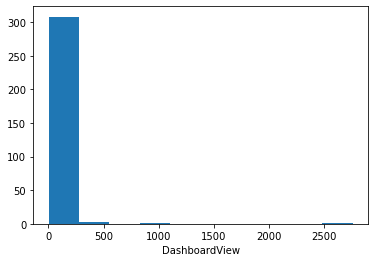

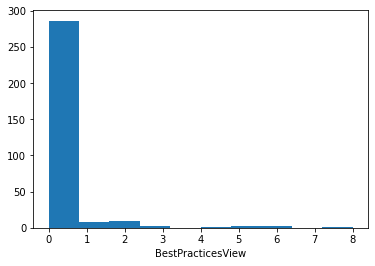

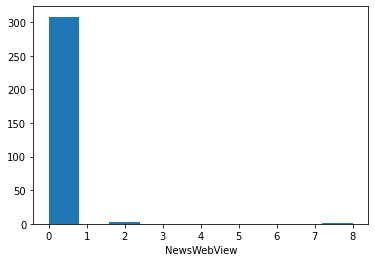

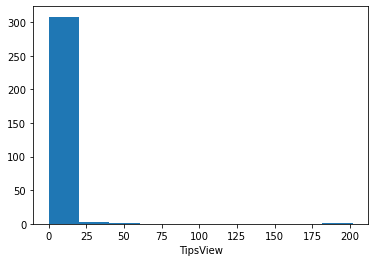

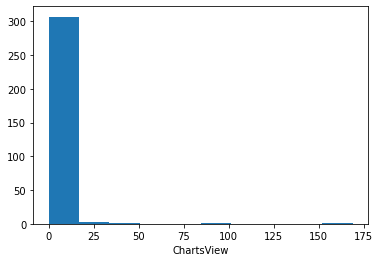

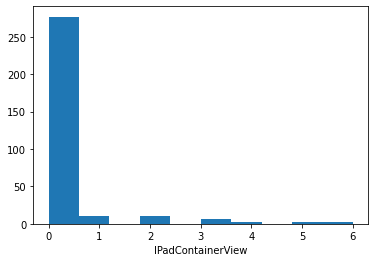

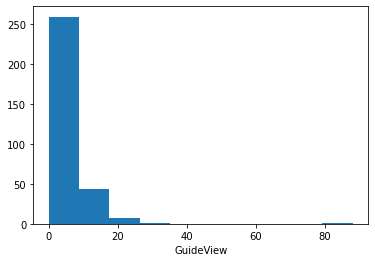

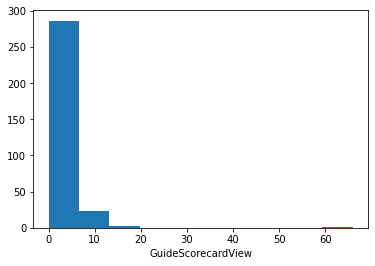

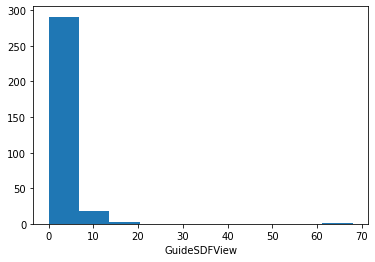

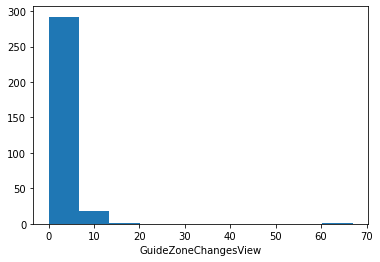

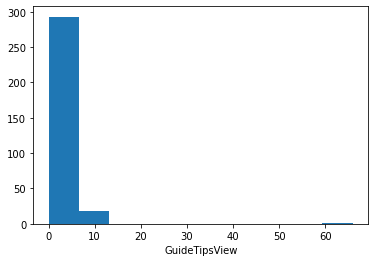

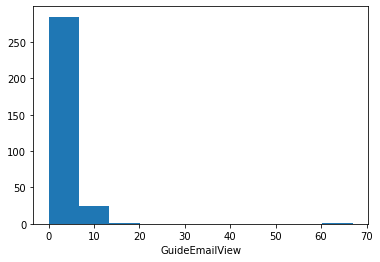

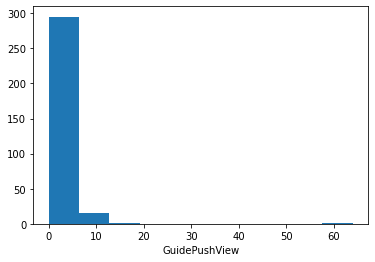

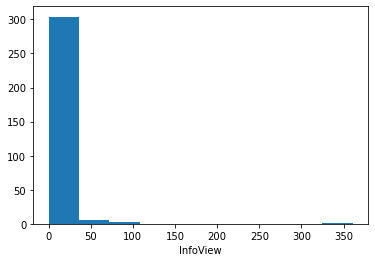

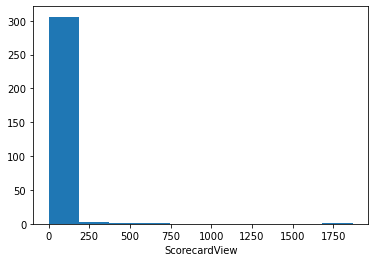

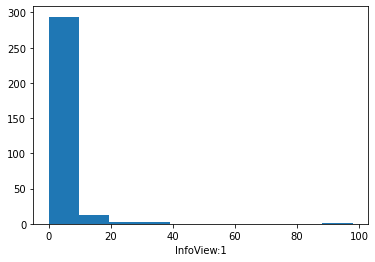

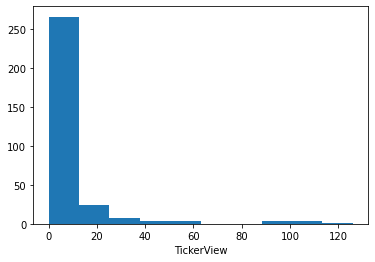

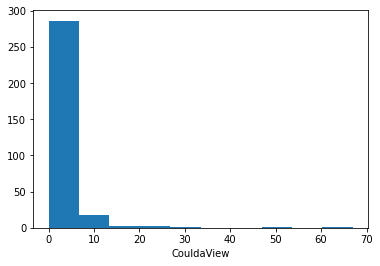

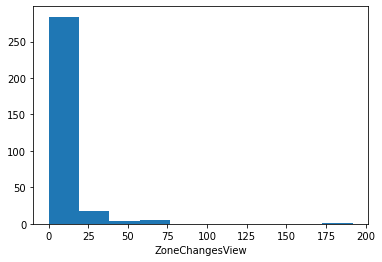

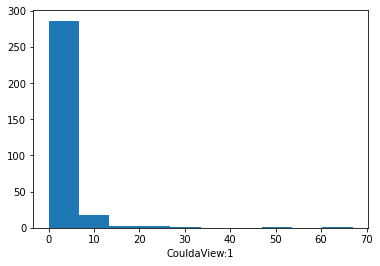

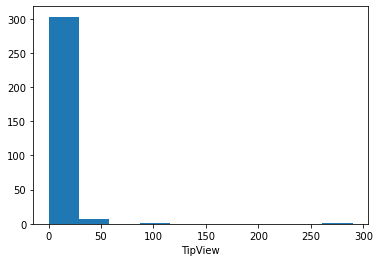

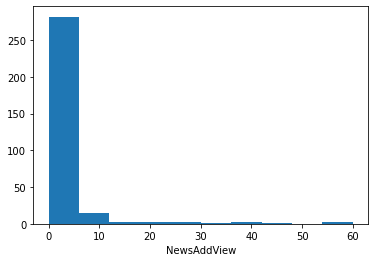

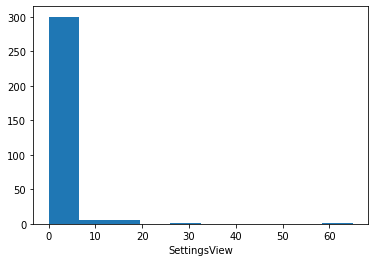

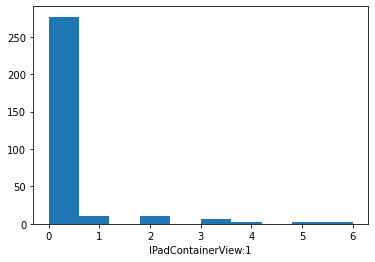

In [29]:

X = subscribed_users_by_view_count.drop('secCode', axis= 1)

for i in X:
    plt.figure(i)
    plt.hist(X[i])
    plt.xlabel(i)
    #plt.savefig('sub30 {0}.jpg'.format(i))
    #plt.close()
    plt.show()

In [17]:
average_subcribeduser_view = sqldf("""
        select 
             avg(DashboardView) as avg_Dashboard
            , avg(BestPracticesView) as avg_BestPractices
            , avg(NewsWebView) as avg_NewsWeb
            , avg(TipsView) as avg_Tips
            , avg(ChartsView) as_charts
            , avg(IPadContainerView) as avg_IPaadcontainer
            , avg(GuideView) as avg_Guide
            , avg(GuideScorecardView) as avg_GuideScorecard
            , avg(GuideSDFView) as avg_GuideSDF
            , avg(GuideZoneChangesView) as avg_GuideZonechanges
            , avg(GuideTipsView) as avg_GuideTips
            , avg(GuideEmailView) as avg_GuideEmail
            , avg(GuidePushView) as avg_GuidePush
            , avg(InfoView) as avg_Info
            , avg(ScorecardView) as avg_Scorecard
            , avg(InfoView) as avg_Info
            , avg(TickerView) as avg_Ticker
        from secCode_individual_view_count

""")

average_subcribeduser_view

PandaSQLException: (sqlite3.OperationalError) no such table: secCode_individual_view_count
[SQL: 
        select 
             avg(DashboardView) as avg_Dashboard
            , avg(BestPracticesView) as avg_BestPractices
            , avg(NewsWebView) as avg_NewsWeb
            , avg(TipsView) as avg_Tips
            , avg(ChartsView) as_charts
            , avg(IPadContainerView) as avg_IPaadcontainer
            , avg(GuideView) as avg_Guide
            , avg(GuideScorecardView) as avg_GuideScorecard
            , avg(GuideSDFView) as avg_GuideSDF
            , avg(GuideZoneChangesView) as avg_GuideZonechanges
            , avg(GuideTipsView) as avg_GuideTips
            , avg(GuideEmailView) as avg_GuideEmail
            , avg(GuidePushView) as avg_GuidePush
            , avg(InfoView) as avg_Info
            , avg(ScorecardView) as avg_Scorecard
            , avg(InfoView) as avg_Info
            , avg(TickerView) as avg_Ticker
        from secCode_individual_view_count

]
(Background on this error at: http://sqlalche.me/e/13/e3q8)

# Unsubscribed secCode by indidvialview count

In [33]:
unsubscribed_user_view_count =  """
    with t1 as(
        select *
        from new_df
        where lastSubscrib != 'Y'
    ),
    t2 as 
            (
            select 
                secCode
                , sum(case when view = 'DashboardViewController' then 1 else 0 
                    end) as DashboardView 
                , sum(case when view = 'BestPracticesViewController' then 1 else 0 
                    end) as BestPracticesView
                , sum(case when view = 'NewsWebViewController' then 1 else 0 
                    end) as NewsWebView
                , sum(case when view = 'TipsViewController' then 1 else 0 
                    end) as TipsView
                , sum(case when view = 'ChartsViewController' then 1 else 0 
                    end) as ChartsView       
                , sum(case when view = 'IPadContainerViewController' then 1 else 0 
                    end) as IPadContainerView  
                , sum(case when view = 'GuideViewController' then 1 else 0 
                    end) as GuideView
                , sum(case when view = 'GuideScorecardViewController' then 1 else 0 
                    end) as GuideScorecardView
                , sum(case when view = 'GuideSDFViewController' then 1 else 0 
                    end) as GuideSDFView
                , sum(case when view = 'GuideZoneChangesViewController' then 1 else 0 
                    end) as GuideZoneChangesView
                , sum(case when view = 'GuideTipsViewController' then 1 else 0 
                    end) as GuideTipsView
                , sum(case when view = 'GuideEmailViewController' then 1 else 0 
                    end) as GuideEmailView
                , sum(case when view = 'GuidePushViewController' then 1 else 0 
                    end) as GuidePushView
                , sum(case when view = 'InfoViewController' then 1 else 0 
                    end) as InfoView
                , sum(case when view = 'ScorecardViewController' then 1 else 0 
                    end) as ScorecardView
                , sum(case when view = 'NewsViewController' then 1 else 0 
                    end) as InfoView
                , sum(case when view = 'TickerViewController' then 1 else 0 
                    end) as TickerView
                , sum(case when view = 'CouldaViewController' then 1 else 0 
                    end) as CouldaView
                , sum(case when view = 'ZoneChangesViewController' then 1 else 0 
                    end) as ZoneChangesView
                , sum(case when view = 'CouldaViewController' then 1 else 0 
                    end) as CouldaView
                , sum(case when view = 'TipViewController' then 1 else 0 
                    end) as TipView
                , sum(case when view = 'NewsAddViewController' then 1 else 0 
                    end) as NewsAddView
                , sum(case when view = 'SettingsViewController' then 1 else 0 
                    end) as SettingsView
                , sum(case when view = 'IPadContainerViewController' then 1 else 0 
                    end) as IPadContainerView                 
            from t1
            group by 1
            )
        
    select 
        *
    from t2
    order by 2 desc
    
    """

In [34]:
unsubscribed_users_by_view_count = sqldf(unsubscribed_user_view_count)
unsubscribed_users_by_view_count

,secCode,DashboardView,BestPracticesView,NewsWebView,TipsView,ChartsView,IPadContainerView,GuideView,GuideScorecardView,GuideSDFView,...,ScorecardView,InfoView:1,TickerView,CouldaView,ZoneChangesView,CouldaView:1,TipView,NewsAddView,SettingsView,IPadContainerView:1
0,0F749FF2-A962-4816-8890-5A544A77B95C,109,0,0,0,0,0,2,1,1,...,1,0,0,1,0,1,0,0,0,0
1,908455D6-C64A-4AA3-AC2F-2EF37CCE7BCD,95,3,2,2,1,0,9,9,8,...,17,5,3,1,3,1,11,3,5,0
2,0B0F29A6-D8EB-4D98-892F-14B39973612C,88,0,0,0,0,0,1,0,0,...,0,0,1,2,0,2,2,0,0,0
3,540AD7A6-FD4C-4431-8FC0-0F4EE70D4C31,72,0,0,5,0,0,17,3,2,...,2,3,5,1,2,1,5,18,2,0
4,9FF6E99A-60AD-4F9E-BE23-CDCCB08C9920,67,0,0,0,0,0,11,7,7,...,1,0,0,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,FCEB0B9F-7980-4414-84F8-A56882F52020,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3496,FD5DD76E-6DC5-4595-A135-920733BA61E2,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3497,FD989BB7-58AD-4691-9337-76AD315C07B5,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3498,FE17AA19-EB40-40B6-B124-DEE1E0EC414E,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


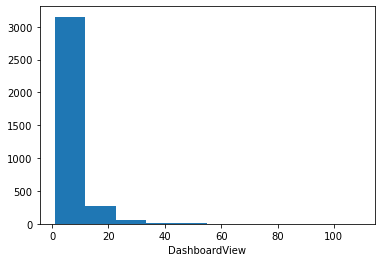

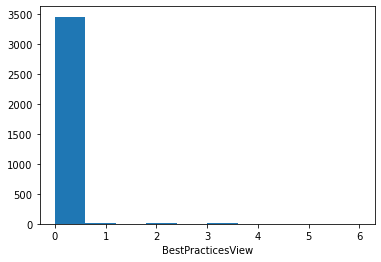

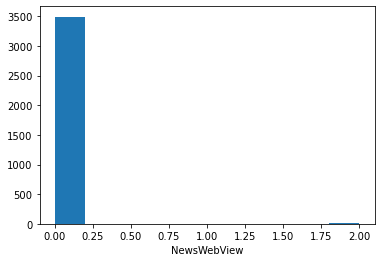

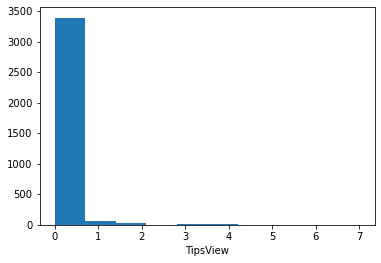

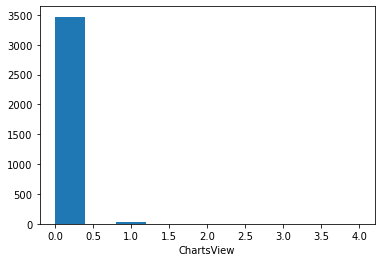

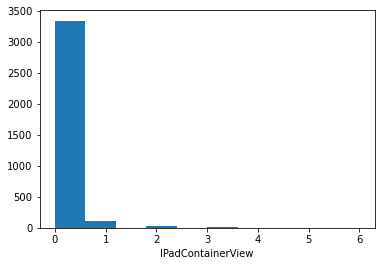

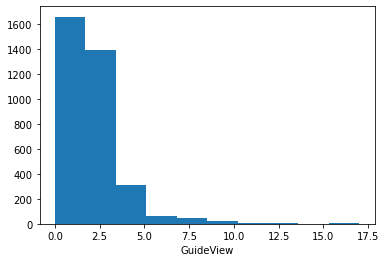

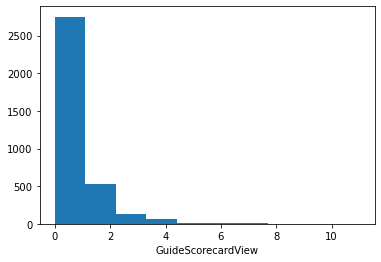

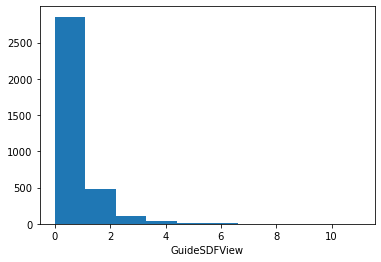

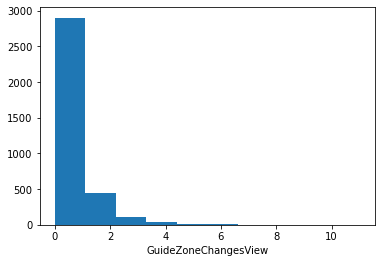

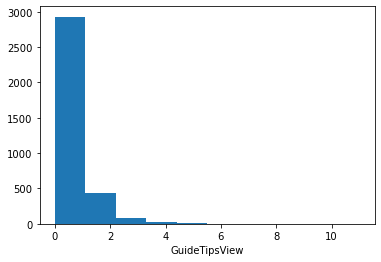

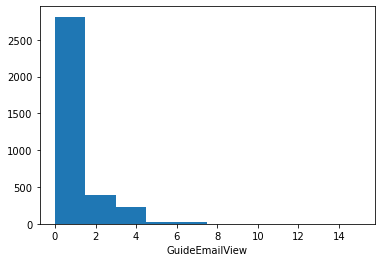

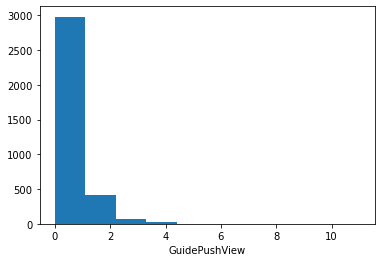

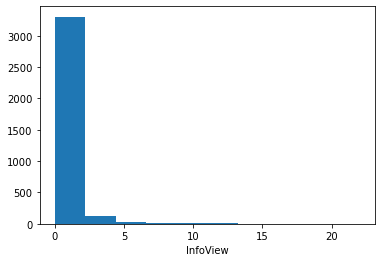

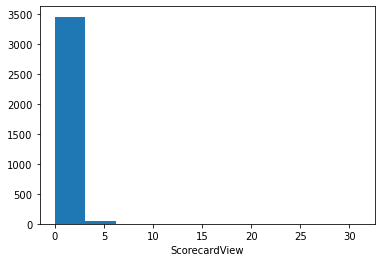

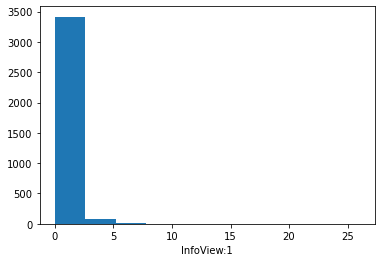

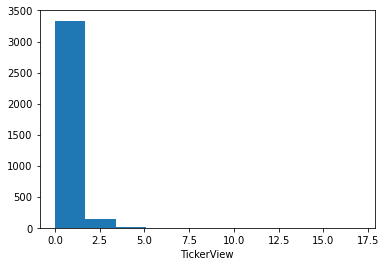

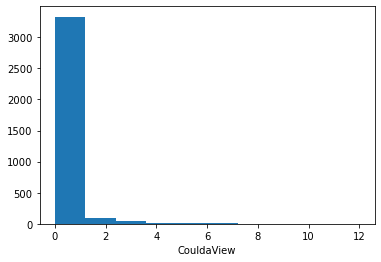

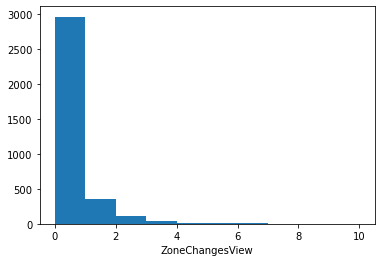

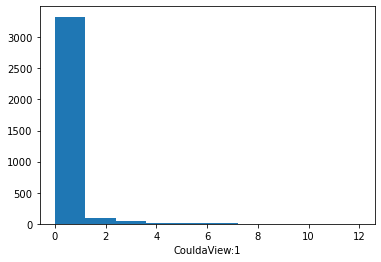

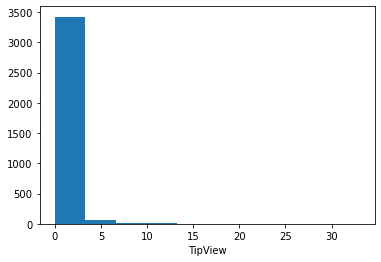

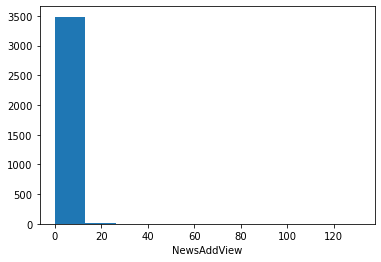

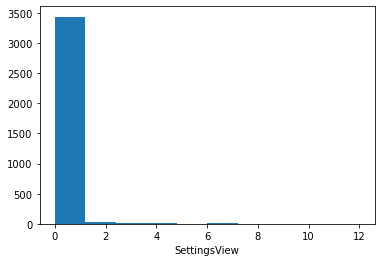

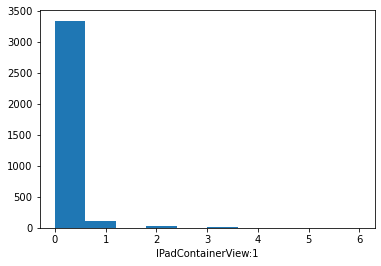

In [35]:
X = unsubscribed_users_by_view_count.drop('secCode', axis= 1)

for i in X:
    plt.figure(i)
    plt.hist(X[i])
    plt.xlabel(i)
    #plt.savefig('sub30 {0}.jpg'.format(i))
    #plt.close()
    plt.show()

In [38]:
average_unsubscribed_user_view = sqldf("""
        select 
             avg(DashboardView) as avg_Dashboard
            , avg(BestPracticesView) as avg_BestPractices
            , avg(NewsWebView) as avg_NewsWeb
            , avg(TipsView) as avg_Tips
            , avg(ChartsView) as_charts
            , avg(IPadContainerView) as avg_IPaadcontainer
            , avg(GuideView) as avg_Guide
            , avg(GuideScorecardView) as avg_GuideScorecard
            , avg(GuideSDFView) as avg_GuideSDF
            , avg(GuideZoneChangesView) as avg_GuideZonechanges
            , avg(GuideView) as avg_Guide
            , avg(GuideTipsView) as avg_GuideTips
            , avg(GuideEmailView) as avg_GuideEmail
            , avg(GuidePushView) as avg_GuidePush
            , avg(InfoView) as avg_Info
            , avg(ScorecardView) as avg_Scorecard
            , avg(InfoView) as avg_Info
            , avg(TickerView) as avg_Ticker
        from unsubscribed_users_by_view_count

""")

In [37]:
average_unsubscribed_user_view

,avg_Dashboard,avg_BestPractices,avg_NewsWeb,avg_Tips,as_charts,avg_IPaadcontainer,avg_Guide,avg_GuideScorecard,avg_GuideSDF,avg_GuideZonechanges,avg_Guide,avg_GuideTips,avg_GuideEmail,avg_GuidePush,avg_Info,avg_Scorecard,avg_Info,avg_Ticker
0,5.662571,0.026,0.003429,0.054,0.011143,0.066286,2.028286,1.105143,1.022857,0.980857,2.028286,0.952,1.071143,0.897143,0.470857,0.34,0.470857,0.256286


In [118]:
average_subcribeduser_view

,avg_Dashboard,avg_BestPractices,avg_NewsWeb,avg_Tips,as_charts,avg_IPaadcontainer,avg_Guide,avg_GuideScorecard,avg_GuideSDF,avg_GuideZonechanges,avg_Guide,avg_GuideTips,avg_GuideEmail,avg_GuidePush,avg_Info,avg_Scorecard,avg_Info,avg_Ticker
0,49.99359,0.217949,0.044872,1.974359,2.451923,0.275641,5.121795,2.791667,2.564103,2.445513,5.121795,2.407051,2.724359,2.291667,8.772436,22.173077,8.772436,7.746795


# Time in  app per View

In [268]:
q  = """
    select 
        view 
        , avg(sec_length) Avg_time_per_view_hrs

    from new_df
    group by 1
    order by 2 desc
    
    """

sqldf(q)


Avg_feature_use = sqldf(q)
Avg_feature_use

,view,Avg_time_per_view_hrs
0,IPadContainerViewController,663734.957746
1,DashboardViewController,234476.112963
2,GuideViewController,212558.124153
3,SettingsViewController,155684.935047
4,SubscriptionViewController,148781.028930
5,NewsViewController,135080.277043
6,CouldaViewController,105409.448708
7,TickerViewController,66668.490497
8,InfoViewController,66233.858660
9,ZoneChangesViewController,59386.393613


In [67]:
q = """
    with t1 as(
            select 
                secCode
                , round(avg(case when view = 'DashboardViewController' then sec_length else 0 
                    end), 2) as DashboardView 
                , round(avg(case when view = 'BestPracticesViewController' then sec_length else 0 
                    end), 2) as BestPracticesView
                , round(avg(case when view = 'NewsWebViewController' then sec_length else 0 
                    end), 2) as NewsWebView
                , avg(case when view = 'TipsViewController' then sec_length else 0 
                    end) as TipsView
                , avg(case when view = 'ChartsViewController' then sec_length else 0 
                    end) as ChartsView       
                , avg(case when view = 'IPadContainerViewController' then sec_length else 0 
                    end) as IPadContainerView  
                , avg(case when view = 'GuideViewController' then sec_length else 0 
                    end) as GuideView
                , avg(case when view = 'GuideScorecardViewController' then sec_length else 0 
                    end) as GuideScorecardView
                , avg(case when view = 'GuideSDFViewController' then sec_length else 0 
                    end) as GuideSDFView
                , avg(case when view = 'GuideZoneChangesViewController' then sec_length else 0 
                    end) as GuideZoneChangesView
                , avg(case when view = 'GuideTipsViewController' then sec_length else 0 
                    end) as GuideTipsView
                , avg(case when view = 'GuideEmailViewController' then sec_length else 0 
                    end) as GuideEmailView
                , avg(case when view = 'GuidePushViewController' then sec_length else 0 
                    end) as GuidePushView
                , avg(case when view = 'InfoViewController' then sec_length else 0 
                    end) as InfoView
                , avg(case when view = 'ScorecardViewController' then sec_length else 0 
                    end) as ScorecardView
                , avg(case when view = 'TickerViewController' then sec_length else 0 
                    end) as TickerView
                , avg(case when view = 'CouldaViewController' then sec_length else 0 
                    end) as CouldaView
                , avg(case when view = 'ZoneChangesViewController' then sec_length else 0 
                    end) as ZoneChangesView
                , avg(case when view = 'CouldaViewController' then sec_length else 0 
                    end) as CouldaView
                , avg(case when view = 'NewsAddViewController' then sec_length else 0 
                    end) as NewsAddView
                , avg(case when view = 'SettingsViewController' then sec_length else 0 
                    end) as SettingsView    
           
            from new_df
            group by 1
            order by 2 desc
            )
        
    select 
        *
    from t1
    
    
    """

sqldf(q)


secCode_by_Time= sqldf(q)
secCode_by_Time.head()

,secCode,DashboardView,BestPracticesView,NewsWebView,TipsView,ChartsView,IPadContainerView,GuideView,GuideScorecardView,GuideSDFView,...,GuideEmailView,GuidePushView,InfoView,ScorecardView,TickerView,CouldaView,ZoneChangesView,CouldaView:1,NewsAddView,SettingsView
0,793C0D59-9ECC-4C0B-A5D4-ED0D8FEC3818,7409269.33,0.0,0.0,0.0,0.0,0.0,20040.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,69D76D90-689A-4781-8CF4-48B6A0BC1B4F,7063607.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,04690D0A-CEE5-4356-A32E-D8E68C3B8901,4780978.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,F4F42245-7C16-4EA8-8D30-1F7D22020C71,4731889.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8F928327-CCD1-4E73-B102-BA5C3DC474EC,4338170.00,0.0,0.0,0.0,0.0,0.0,1.75,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
average_view_time = sqldf("""
        select 
             avg(DashboardView)/60 as avg_Dashboard
            , avg(BestPracticesView)/60 as avg_BestPractices
            , avg(NewsWebView)/60 as avg_NewsWeb
            , avg(TipsView)/60 as avg_Tips
            , avg(ChartsView)/60 as_charts
            , avg(IPadContainerView)/60 as avg_IPaadcontainer
            , avg(GuideView)/60 as avg_Guide
            , avg(GuideScorecardView)/60 as avg_GuideScorecard
            , avg(GuideSDFView)/60 as avg_GuideSDF
            , avg(GuideZoneChangesView)/60 as avg_GuideZonechanges
            , avg(GuideTipsView)/60 as avg_GuideTips
            , avg(GuideEmailView)/60 as avg_GuideEmail
            , avg(GuidePushView)/60 as avg_GuidePush
            , avg(InfoView)/60 as avg_Info
            , avg(ScorecardView)/60 as avg_Scorecard
            , avg(InfoView)/60 as avg_Info
            , avg(TickerView)/60 as avg_Ticker
        from secCode_by_Time

""")

average_view_time

,avg_Dashboard,avg_BestPractices,avg_NewsWeb,avg_Tips,as_charts,avg_IPaadcontainer,avg_Guide,avg_GuideScorecard,avg_GuideSDF,avg_GuideZonechanges,avg_GuideTips,avg_GuideEmail,avg_GuidePush,avg_Info,avg_Scorecard,avg_Info,avg_Ticker
0,1797.18634,0.775781,0.061357,6.694672,0.711611,52.204968,820.757344,48.492565,23.38567,34.153817,15.000182,45.685571,5.672146,40.542148,25.47922,40.542148,12.060526


In [8]:
X = secCode_by_Time.drop('secCode', axis= 1)

for i in X:
    plt.figure(i)
    plt.hist(X[i])
    plt.xlabel(i)
    #plt.savefig('sub30 {0}.jpg'.format(i))
    #plt.close()
    plt.show()

In [48]:
for col in X:
    print( col , ':', X[col].std(), "mean", ':', X[col].mean())

DashboardView : 371369.88648710493 mean : 108710.29793629528
BestPracticesView : 1795.2869654801118 mean : 46.68252885624347
NewsWebView : 226.97511689131943 mean : 3.6814821615949636
TipsView : 15680.206174336647 mean : 402.55276388707983
ChartsView : 1187.2585451420657 mean : 42.73206170564517
IPadContainerView : 74961.79698123566 mean : 3145.836786083682
GuideView : 313604.3204217859 mean : 49319.12297362706
GuideScorecardView : 59628.891487628156 mean : 2943.8222404766957
GuideSDFView : 30861.662026871625 mean : 1403.419037654459
GuideZoneChangesView : 39369.835043916246 mean : 2049.9337505227218
GuideTipsView : 20313.62462099769 mean : 900.0132142715651
GuideEmailView : 58064.29501110795 mean : 2741.2854505076507
GuidePushView : 7981.171399548687 mean : 342.1930332456129
InfoView : 29064.259780644326 mean : 2570.6807777158697
ScorecardView : 17901.58977169055 mean : 1529.9171912623694
InfoView:1 : 15447.500772263671 mean : 1095.6309611417614
TickerView : 12972.07268297125 mean : 7

In [62]:
#obtaining the upper and lower boundaries for all views

for col in X:
    std =  X[col].std()
    mean = X[col].mean()
    upper_bound = mean + 2*std
    lower_bound = mean - 2*std
    print(col, "Upper: ",upper_bound , " Lower: ",lower_bound)
    
    

DashboardView Upper:  851450.0709105051  Lower:  -634029.4750379146
BestPracticesView Upper:  3637.256459816467  Lower:  -3543.89140210398
NewsWebView Upper:  457.6317159442338  Lower:  -450.2687516210439
TipsView Upper:  31762.965112560374  Lower:  -30957.859584786213
ChartsView Upper:  2417.2491519897767  Lower:  -2331.785028578486
IPadContainerView Upper:  153069.430748555  Lower:  -146777.75717638765
GuideView Upper:  676527.7638171988  Lower:  -577889.5178699447
GuideScorecardView Upper:  122201.60521573301  Lower:  -116313.96073477961
GuideSDFView Upper:  63126.74309139771  Lower:  -60319.90501608879
GuideZoneChangesView Upper:  80789.60383835521  Lower:  -76689.73633730978
GuideTipsView Upper:  41527.262456266944  Lower:  -39727.23602772381
GuideEmailView Upper:  118869.87547272355  Lower:  -113387.30457170824
GuidePushView Upper:  16304.535832342986  Lower:  -15620.149765851762
InfoView Upper:  60699.20033900452  Lower:  -55557.838783572784
ScorecardView Upper:  37333.096734643

In [ ]:
 # Analysis of Dashboard view

In [69]:
dashview_time = """
    with t1 as (
            select  
                *
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where DashboardView < 851450.0709105051
            ) 
    
    )
    select 
        *
    from t1

    """


try3 = sqldf(dashview_time)
try3

,secCode,DashboardView,BestPracticesView,NewsWebView,TipsView,ChartsView,IPadContainerView,GuideView,GuideScorecardView,GuideSDFView,...,GuideEmailView,GuidePushView,InfoView,ScorecardView,TickerView,CouldaView,ZoneChangesView,CouldaView:1,NewsAddView,SettingsView
0,2A75B5AB-E687-4090-B655-ECAD6F872242,844542.18,0.0,0.0,0.0,0.0,0.0,0.250000,0.176471,0.058824,...,0.117647,10132.058824,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,F1B89FE9-9E46-406A-91EC-70F3F658DE0C,842182.71,0.0,0.0,0.0,0.0,0.0,0.923077,0.857143,0.285714,...,0.500000,0.214286,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,9E261178-17CE-432B-8DDF-986899F5F74C,840087.10,0.0,0.0,0.0,0.0,0.0,44289.863636,0.136364,0.136364,...,0.045455,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,F3FE29C3-F7FB-423A-B88F-381515A1AD51,839727.56,0.0,0.0,0.0,0.0,0.0,572494.115385,0.153846,0.192308,...,0.038462,0.115385,0.0,0.0,33232.230769,0.0,0.0,0.0,0.0,0.0
4,6871A57E-1A2B-45DB-B7CF-A7DA3EC273B4,837533.00,0.0,0.0,0.0,0.0,0.0,1.307692,0.692308,0.500000,...,0.384615,0.230769,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3613,015A09AB-8721-462A-B4FB-9E6AA403C1E6,0.00,0.0,0.0,0.0,0.0,0.0,0.222222,0.222222,0.111111,...,0.111111,0.222222,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3614,0136ED78-D494-4545-AC7D-C79543AFEF63,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3615,01207A56-1F2F-40F8-972B-A7323E51BF0F,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3616,00AAB63E-EF73-4E9A-A199-0CA178C1C6F0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


# Analysis of Dashboard View

In [70]:
dashview_time = """
    with t1 as (
            select  
                DashboardView 
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where DashboardView < 851450.0709105051
            ) 
    
    )
    select 
        *
    from t1

    """


try1 = sqldf(dashview_time)
try1

,DashboardView
0,844542.18
1,842182.71
2,840087.10
3,839727.56
4,837533.00
...,...
3613,0.00
3614,0.00
3615,0.00
3616,0.00


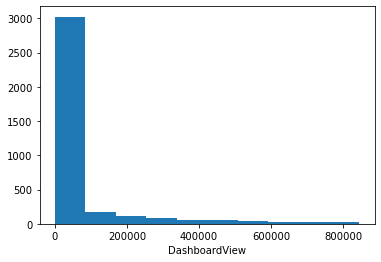

In [71]:
#plt.figure(DashboardView)
plt.hist(try1['DashboardView'])
plt.xlabel('DashboardView')
plt.show()

In [72]:
try1['DashboardView'].mean() + try1['DashboardView'].std()

200366.63924578583

In [80]:
try1['DashboardView'].mean() - try1['DashboardView'].std()

-85871.53447248953

In [74]:
dashview_time = """
    with t1 as (
            select  
                DashboardView 
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where DashboardView < 200366.63924578583
            ) 
    
    )
    select 
        *
    from t1

    """


try2 = sqldf(dashview_time)
try2

,DashboardView
0,199240.09
1,199193.00
2,197544.50
3,196788.27
4,194785.66
...,...
3241,0.00
3242,0.00
3243,0.00
3244,0.00


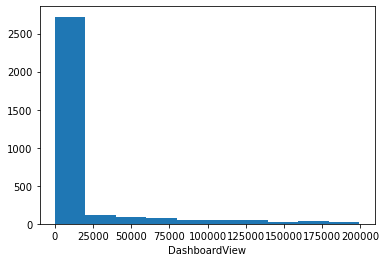

In [75]:
#plt.figure(DashboardView)
plt.hist(try2['DashboardView'])
plt.xlabel('DashboardView')
plt.show()

In [76]:
try2['DashboardView'].mean() + try2['DashboardView'].std()

51261.80269112435

In [77]:
dashview_time = """
    with t1 as (
            select  
                DashboardView 
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where DashboardView < 51261.80269112435
            ) 
    
    )
    select 
        *
    from t1

    """


try3 = sqldf(dashview_time)
try3

,DashboardView
0,51053.39
1,51032.59
2,50992.35
3,50702.41
4,50578.03
...,...
2893,0.00
2894,0.00
2895,0.00
2896,0.00


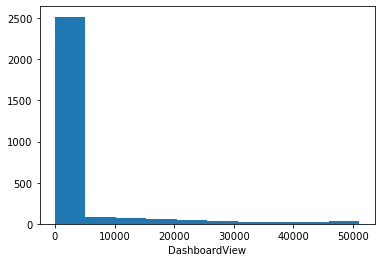

In [78]:
#plt.figure(DashboardView)
plt.hist(try3['DashboardView'])
plt.xlabel('DashboardView')
plt.show()

In [79]:
try3['DashboardView'].mean() + try3['DashboardView'].std()

11949.337276831899

In [80]:
dashview_time = """
    with t1 as (
            select  
                DashboardView 
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where DashboardView < 11949.337276831899
            ) 
    
    )
    select 
        *
    from t1

    """


try4 = sqldf(dashview_time)
try4

,DashboardView
0,11786.32
1,11596.86
2,11428.83
3,11333.53
4,11172.29
...,...
2615,0.00
2616,0.00
2617,0.00
2618,0.00


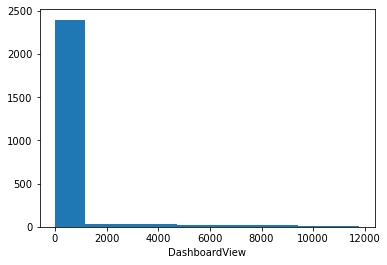

In [81]:
#plt.figure(DashboardView)
plt.hist(try4['DashboardView'])
plt.xlabel('DashboardView')
plt.show()

In [82]:
try4['DashboardView'].mean() + try4['DashboardView'].std()

2208.755041469794

In [83]:
dashview_time = """
    with t1 as (
            select  
                DashboardView 
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where DashboardView < 2208.755041469794
            ) 
    
    )
    select 
        *
    from t1

    """


try5 = sqldf(dashview_time)
try5

,DashboardView
0,2173.31
1,2170.94
2,2126.22
3,2094.20
4,2009.00
...,...
2426,0.00
2427,0.00
2428,0.00
2429,0.00


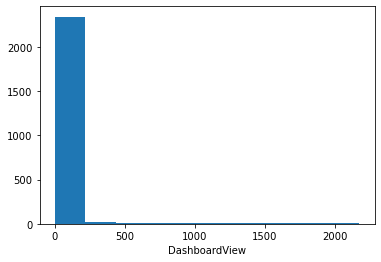

In [84]:
#plt.figure(DashboardView)
plt.hist(try5['DashboardView'])
plt.xlabel('DashboardView')
plt.show()

In [85]:
try5['DashboardView'].mean() + try5['DashboardView'].std()

255.65000544117171

In [86]:
dashview_time = """
    with t1 as (
            select  
                DashboardView 
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where DashboardView < 255.65000544117171
            ) 
    
    )
    select 
        *
    from t1

    """


try6 = sqldf(dashview_time)
try6

,DashboardView
0,252.12
1,246.76
2,239.86
3,231.73
4,231.31
...,...
2345,0.00
2346,0.00
2347,0.00
2348,0.00


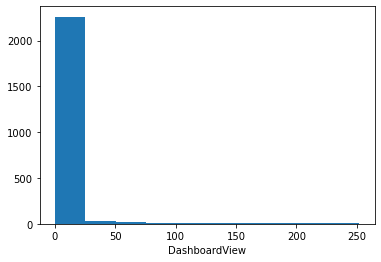

In [87]:
#plt.figure(DashboardView)
plt.hist(try6['DashboardView'])
plt.xlabel('DashboardView')
plt.show()

In [111]:
try6['DashboardView'].mean() + try6['DashboardView'].std()

30.588921347177788

In [89]:
dashview_time = """
    with t1 as (
            select  
                DashboardView 
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where DashboardView < 30.588921347177788
            ) 
    
    )
    select 
        *
    from t1

    """


try7 = sqldf(dashview_time)
try7

,DashboardView
0,30.42
1,29.48
2,28.33
3,27.50
4,27.41
...,...
2266,0.00
2267,0.00
2268,0.00
2269,0.00


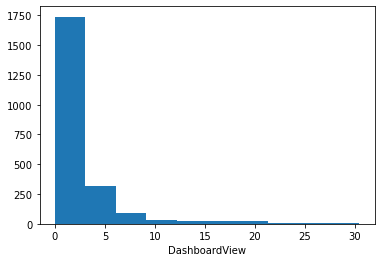

In [90]:
#plt.figure(DashboardView)
plt.hist(try7['DashboardView'])
plt.xlabel('DashboardView')
plt.show()

In [91]:
try7['DashboardView'].mean() + 2*try7['DashboardView'].std()

10.599716006589954

In [92]:
dashview_time = """
    with t1 as (
            select  
                DashboardView 
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where DashboardView < 10.729013514379925
            ) 
    
    )
    select 
        *
    from t1

    """


try8 = sqldf(dashview_time)


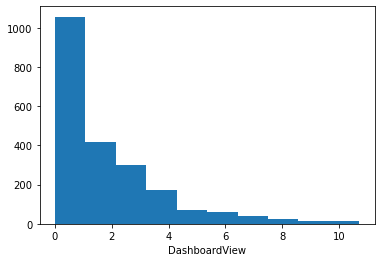

In [93]:
#plt.figure(DashboardView)
plt.hist(try8['DashboardView'])
plt.xlabel('DashboardView')
#plt.savefig('dashboard{0}.jpg'.format(i))
plt.show()

In [95]:
Dashboard = sqldf("""
            select 
                count(distinct secCode) secCode_count
                , (count(distinct secCode)*1.0)/(select count(distinct secCode) from new_df) as Percent_Dashboard
            from secCode_by_Time
            where DashboardView  < 10.729013514379925
            """)
Dashboard

,secCode_count,Percent_Dashboard
0,2166,0.568206


# Analysis of GuideView

In [ ]:
GuideView : 313604.3204217859 mean : 49319.12297362706

In [123]:
49319.12297362706 + 2*313604.3204217859

676527.7638171988

In [96]:
GuideView = """
    with t1 as (
            select  
                GuideView 
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where GuideView < 676527.7638171988
            ) 
    
    )
    select 
        *
    from t1

    """


Guide1 = sqldf(GuideView)
Guide1

,GuideView
0,20040.00
1,0.00
2,0.00
3,0.00
4,1.75
...,...
3729,0.00
3730,0.00
3731,0.00
3732,0.00


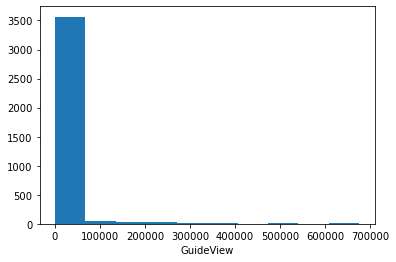

In [126]:
#plt.figure(DashboardView)
plt.hist(Guide1['GuideView'])
plt.xlabel('GuideView')
plt.show()

In [135]:
Guide1['GuideView'].mean() + Guide1['GuideView'].std()

75061.07073313772

In [137]:
GuideView = """
    with t1 as (
            select  
                GuideView 
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where GuideView < 75061.07073313772
            ) 
    
    )
    select 
        *
    from t1

    """


Guide2 = sqldf(GuideView)


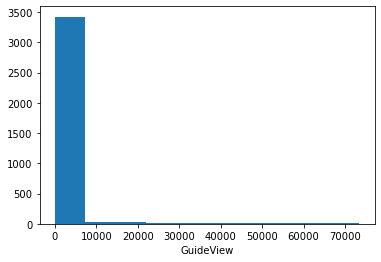

In [138]:

plt.hist(Guide2['GuideView'])
plt.xlabel('GuideView')

plt.show()

In [139]:
Guide2['GuideView'].mean() + Guide2['GuideView'].std()

8814.577604928792

In [140]:
GuideView = """
    with t1 as (
            select  
                GuideView 
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where GuideView < 8814.577604928792
            ) 
    
    )
    select 
        *
    from t1

    """


Guide3 = sqldf(GuideView)


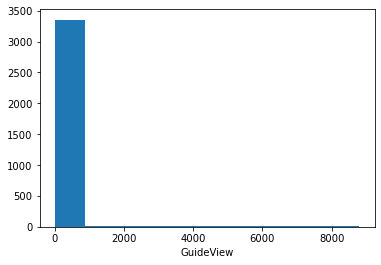

In [141]:
#plt.figure(DashboardView)
plt.hist(Guide3['GuideView'])
plt.xlabel('GuideView')
plt.show()

In [147]:
Guide3['GuideView'].mean() + Guide3['GuideView'].std()

854.4704684388769

In [148]:
GuideView = """
    with t1 as (
            select  
                GuideView 
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where GuideView < 854.4704684388769
            ) 
    
    )
    select 
        *
    from t1

    """


Guide4 = sqldf(GuideView)


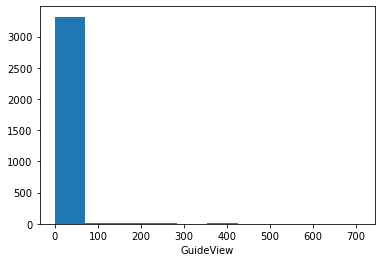

In [149]:
#plt.figure(DashboardView)
plt.hist(Guide4['GuideView'])
plt.xlabel('GuideView')
plt.show()

In [150]:
Guide4['GuideView'].mean() + Guide4['GuideView'].std()

35.055939475952385

In [153]:
GuideView = """
    with t1 as (
            select  
                GuideView 
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where GuideView < 35.055939475952385
            ) 
    
    )
    select 
        *
    from t1

    """


Guide5 = sqldf(GuideView)

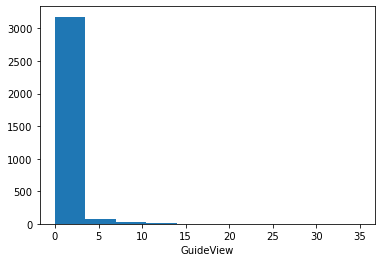

In [154]:
plt.hist(Guide5['GuideView'])
plt.xlabel('GuideView')
plt.show()

In [159]:
Guide5['GuideView'].mean() + 2*Guide5['GuideView'].std()

5.194286782512194

In [12]:
GuideView = """
    with t1 as (
            select  
                GuideView 
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where GuideView < 5.194286782512194
            ) 
    
    )
    select 
        *
    from t1

    """


Guide6 = sqldf(GuideView)

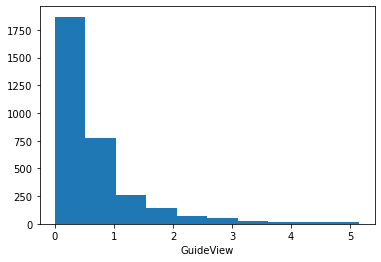

In [98]:
plt.hist(Guide6['GuideView'])
plt.xlabel('GuideView')
plt.savefig('guideview{0}.jpg'.format(i))
plt.show()

In [99]:
GuideView = sqldf("""
            select 
                count(distinct secCode) secCode_count
                , (count(distinct secCode)*1.0)/(select count(distinct secCode) from new_df) as Percent_GuideView
            from secCode_by_Time
            where GuideView  < 5.194286782512194
            """)
GuideView

,secCode_count,Percent_GuideView
0,3228,0.8468


In [210]:
# to find secCode with normal view time-in-app
Guide_Sec_analysis = sqldf(
            """
            select secCode
            from secCode_individual_view_count
            where GuideView  < 5.194286782512194
            
            """
)

Guide_Sec_analysis

,secCode
0,D9C9EE89-5725-4C3E-B196-7E1B3C05BCAE
1,BF76277D-4689-454F-BADD-215FB14CAEE9
2,0F749FF2-A962-4816-8890-5A544A77B95C
3,668239A6-C295-4876-B861-9C6462037898
4,9BA03070-4672-4FCC-BF9E-18965E18394A
...,...
3570,FCEB0B9F-7980-4414-84F8-A56882F52020
3571,FD5DD76E-6DC5-4595-A135-920733BA61E2
3572,FD989BB7-58AD-4691-9337-76AD315C07B5
3573,FE17AA19-EB40-40B6-B124-DEE1E0EC414E


In [213]:
# Analyze random secCode journey within the boundary
Guide_Sec_analysis = sqldf(
            """
            select *
            from new_df
            where secCode  = '9BA03070-4672-4FCC-BF9E-18965E18394A'
            
            """
)

Guide_Sec_analysis

,id,secCode,view,action,detail,transactions,url,articleId,movie,promoCode,isSubscribed,timestamp,activity_order,lead_ts,lastSubscrib,last_act,Sec_length,time_spent
0,55109,9BA03070-4672-4FCC-BF9E-18965E18394A,DashboardViewController,viewWillAppear,none,,,,,,N,2020-12-16 19:54:54,1,2020-12-16 19:54:54,Y,1,0.0,0
1,55110,9BA03070-4672-4FCC-BF9E-18965E18394A,GuideViewController,guideViewWillAppear,none,,,,,,N,2020-12-16 19:54:54,2,2020-12-16 19:54:56,Y,1,2.0,1
2,55111,9BA03070-4672-4FCC-BF9E-18965E18394A,GuideScorecardViewController,guideViewWillAppear,none,,,,,,N,2020-12-16 19:54:56,3,2020-12-16 19:55:06,Y,1,10.0,1
3,55112,9BA03070-4672-4FCC-BF9E-18965E18394A,GuideSDFViewController,guideViewWillAppear,none,,,,,,N,2020-12-16 19:55:06,4,2020-12-16 19:55:10,Y,1,4.0,1
4,55113,9BA03070-4672-4FCC-BF9E-18965E18394A,GuideZoneChangesViewController,guideViewWillAppear,none,,,,,,N,2020-12-16 19:55:10,5,2020-12-16 19:56:25,Y,1,75.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,106700,9BA03070-4672-4FCC-BF9E-18965E18394A,GuideZoneChangesViewController,guideViewWillAppear,none,,,,,,Y,2021-08-02 17:38:51,316,2021-08-02 17:38:55,Y,1,4.0,1
316,106701,9BA03070-4672-4FCC-BF9E-18965E18394A,GuideTipsViewController,guideViewWillAppear,none,,,,,,Y,2021-08-02 17:38:55,317,2021-08-02 17:38:57,Y,1,2.0,1
317,106702,9BA03070-4672-4FCC-BF9E-18965E18394A,GuideEmailViewController,guideViewWillAppear,none,,,,,,Y,2021-08-02 17:38:57,318,2021-08-02 17:38:59,Y,1,2.0,1
318,106703,9BA03070-4672-4FCC-BF9E-18965E18394A,GuidePushViewController,guideViewWillAppear,none,,,,,,Y,2021-08-02 17:38:59,319,2021-08-02 17:39:00,Y,1,1.0,1


In [215]:
# to find secCode with normal view time-in-app
Guide_Sec_analysis_outlier_journey = sqldf(
            """
            select secCode
            from secCode_individual_view_count
            where GuideView  > 5.194286782512194
            
            """
)

Guide_Sec_analysis_outlier_journey

,secCode
0,62870A81-E836-4068-92A5-1B654F16F5B1
1,0D034B75-58D4-4197-8F7B-6CC1F07A5661
2,AB05BBE1-F3A3-43E3-B730-9CBDD069B048
3,FA759AA5-2CCA-4634-A34C-279AAE3ECBDD
4,8124FAAA-5A53-45F3-9847-5525F4FA26DA
...,...
232,8F32C174-7741-4651-8196-11AA5B5A971D
233,BD89EA65-F854-4A95-BA61-2A2EDB52DD2A
234,86EFCF31-834B-4274-95A5-0F45E6A7646A
235,BFF8143D-F06E-4200-B5D2-24D4697E7FCE


In [216]:
# Analyze random secCode journey outside the boundary
Guide_Sec_analysis = sqldf(
            """
            select *
            from new_df
            where secCode  = 'BD89EA65-F854-4A95-BA61-2A2EDB52DD2A'
            
            """
)

Guide_Sec_analysis

,id,secCode,view,action,detail,transactions,url,articleId,movie,promoCode,isSubscribed,timestamp,activity_order,lead_ts,lastSubscrib,last_act,Sec_length,time_spent
0,50024,BD89EA65-F854-4A95-BA61-2A2EDB52DD2A,DashboardViewController,viewWillAppear,none,,,,,,N,2020-11-16 12:41:14,1,2020-11-16 12:41:14,N,1,0.0,0
1,50025,BD89EA65-F854-4A95-BA61-2A2EDB52DD2A,GuideViewController,guideViewWillAppear,none,,,,,,N,2020-11-16 12:41:14,2,2020-11-16 12:41:30,N,1,16.0,1
2,50026,BD89EA65-F854-4A95-BA61-2A2EDB52DD2A,GuideViewController,whatsNew,none,,,,,,N,2020-11-16 12:41:30,3,2020-11-16 12:41:32,N,1,2.0,1
3,50027,BD89EA65-F854-4A95-BA61-2A2EDB52DD2A,GuideViewController,whatsNew,none,,,,,,N,2020-11-16 12:41:32,4,2020-11-16 12:41:54,N,1,22.0,1
4,50028,BD89EA65-F854-4A95-BA61-2A2EDB52DD2A,GuideScorecardViewController,guideViewWillAppear,none,,,,,,N,2020-11-16 12:41:54,5,2020-12-05 19:11:27,N,1,1664973.0,120
5,52819,BD89EA65-F854-4A95-BA61-2A2EDB52DD2A,DashboardViewController,viewWillAppear,none,,,,,,N,2020-12-05 19:11:27,6,2020-12-05 19:11:27,N,1,0.0,0
6,52820,BD89EA65-F854-4A95-BA61-2A2EDB52DD2A,GuideViewController,guideViewWillAppear,none,,,,,,N,2020-12-05 19:11:27,7,2020-12-05 19:11:41,N,1,14.0,1
7,52821,BD89EA65-F854-4A95-BA61-2A2EDB52DD2A,GuideViewController,whatsNew,none,,,,,,N,2020-12-05 19:11:41,8,2020-12-05 19:11:41,N,1,0.0,0
8,52822,BD89EA65-F854-4A95-BA61-2A2EDB52DD2A,GuideViewController,whatsNew,none,,,,,,N,2020-12-05 19:11:41,9,2020-12-05 19:11:50,N,1,9.0,1
9,52823,BD89EA65-F854-4A95-BA61-2A2EDB52DD2A,GuideScorecardViewController,guideViewWillAppear,none,,,,,,N,2020-12-05 19:11:50,10,2020-12-05 19:12:00,N,1,10.0,1


# Analysis of IPadContainerView 

In [ ]:
IPadContainerView : 74961.79698123566 mean : 3145.836786083682

In [162]:
3145.836786083682 + 74961.79698123566

78107.63376731935

In [172]:
IPadContainerView = """
    with t1 as (
            select  
                IPadContainerView
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where IPadContainerView < 78107.63376731935
            ) 
    
    )
    select 
        *
    from t1

    """


IPad1 = sqldf(IPadContainerView)

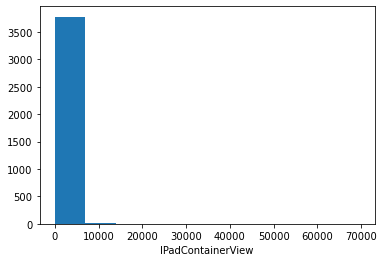

In [171]:

plt.hist(IPad1['IPadContainerView'])
plt.xlabel('IPadContainerView')
plt.show()

In [173]:
IPad1['IPadContainerView'].mean() + IPad1['IPadContainerView'].std()

2671.4073496216133

In [175]:
IPadContainerView = """
    with t1 as (
            select  
                IPadContainerView
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where IPadContainerView < 2671.4073496216133
            ) 
    
    )
    select 
        *
    from t1

    """


IPad2 = sqldf(IPadContainerView)

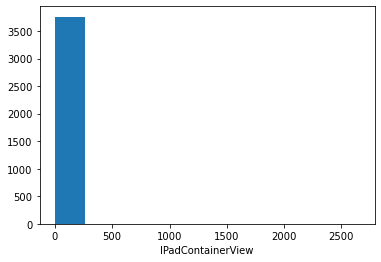

In [176]:
plt.hist(IPad2['IPadContainerView'])
plt.xlabel('IPadContainerView')
plt.show()

In [177]:
IPad2['IPadContainerView'].mean() + IPad2['IPadContainerView'].std()

87.91822768926977

In [178]:
IPadContainerView = """
    with t1 as (
            select  
                IPadContainerView
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where IPadContainerView < 87.91822768926977
            ) 
    
    )
    select 
        *
    from t1

    """


IPad3 = sqldf(IPadContainerView)

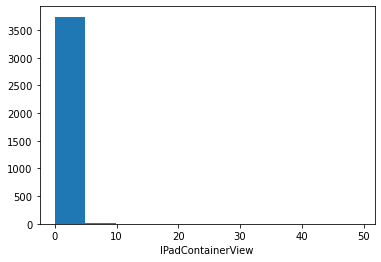

In [179]:
plt.hist(IPad3['IPadContainerView'])
plt.xlabel('IPadContainerView')
plt.show()

In [197]:
IPad3['IPadContainerView'].mean() + IPad3['IPadContainerView'].std()

1.4029455328146598

In [198]:
IPadContainerView = """
    with t1 as (
            select  
                IPadContainerView
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where IPadContainerView < 1.4029455328146598
            ) 
    
    )
    select 
        *
    from t1

    """


IPad4 = sqldf(IPadContainerView)

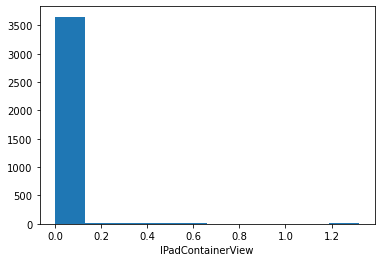

In [199]:
plt.hist(IPad4['IPadContainerView'])
plt.xlabel('IPadContainerView')
plt.show()

In [200]:
IPad4['IPadContainerView'].mean() + 2 *IPad4['IPadContainerView'].std()

0.192270996200219

In [41]:
IPadContainerView = """
    with t1 as (
            select  
                IPadContainerView
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where IPadContainerView < 0.192270996200219
            ) 
    
    )
    select 
        *
    from t1

    """


IPad5 = sqldf(IPadContainerView)

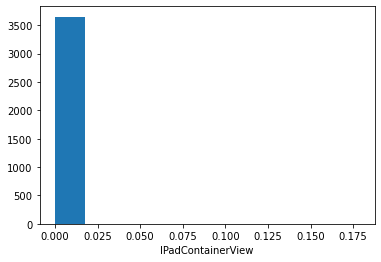

In [42]:
plt.hist(IPad5['IPadContainerView'])
plt.xlabel('IPadContainerView')
plt.savefig('ipadcont{0}.jpg'.format(i))
plt.show()

In [203]:
IPad5['IPadContainerView'].mean() + IPad['IPadContainerView'].std()

0.014165871027120662

In [100]:
IPadContainerView = sqldf("""
            select 
                count(distinct secCode) secCode_count
                , (count(distinct secCode)*1.0)/(select count(distinct secCode) from new_df) as Percent_Dashboard
            from secCode_by_Time 
            where IPadContainerView  < 0.0015328512308400814
            """)
IPadContainerView

,secCode_count,Percent_Dashboard
0,3651,0.957765


# Analysis of BestPracticesView 

In [ ]:
BestPracticesView : 1795.2869654801118 mean : 46.68252885624347

In [217]:
46.68252885624347 + 1795.2869654801118

1841.9694943363552

In [218]:
BestPracticesView = """
    with t1 as (
            select  
                BestPracticesView
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where BestPracticesView < 1841.9694943363552
            ) 
    
    )
    select 
        *
    from t1

    """


BestPrac1 = sqldf(BestPracticesView)

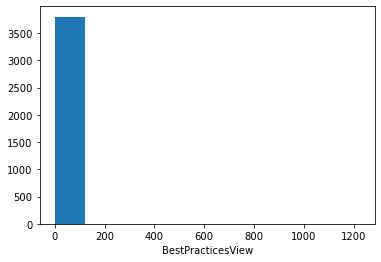

In [219]:
plt.hist(BestPrac1['BestPracticesView'])
plt.xlabel('BestPracticesView')
plt.show()

In [225]:
BestPrac1['BestPracticesView'].mean() + BestPrac1['BestPracticesView'].std()

27.80111961018393

In [223]:
BestPracticesView = """
    with t1 as (
            select  
                BestPracticesView
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where BestPracticesView < 27.80111961018393
            ) 
    
    )
    select 
        *
    from t1

    """


BestPrac2 = sqldf(BestPracticesView)

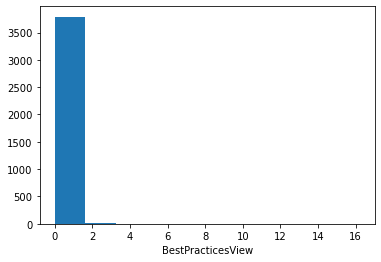

In [224]:
plt.hist(BestPrac2['BestPracticesView'])
plt.xlabel('BestPracticesView')
plt.show()

In [226]:
BestPrac2['BestPracticesView'].mean() + BestPrac2['BestPracticesView'].std()

0.3756994052131699

In [227]:
BestPracticesView = """
    with t1 as (
            select  
                BestPracticesView
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where BestPracticesView < 0.3756994052131699
            ) 
    
    )
    select 
        *
    from t1

    """


BestPrac3 = sqldf(BestPracticesView)

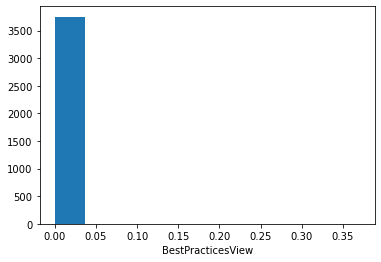

In [228]:
plt.hist(BestPrac3['BestPracticesView'])
plt.xlabel('BestPracticesView')
plt.show()

In [102]:
BestPracticesView = sqldf("""
            select 
                count(distinct secCode) secCode_count
                , (count(distinct secCode)*1.0)/(select count(distinct secCode) from new_df) as Percent_BestPracticesView
            from secCode_by_Time
            where BestPracticesView  < 0.3756994052131699
            """)
BestPracticesView

,secCode_count,Percent_BestPracticesView
0,3773,0.989769


# Analysis of NewsWebView

In [ ]:
NewsWebView : 226.97511689131943 mean : 3.6814821615949636

In [233]:
226.97511689131943 + 3.6814821615949636

230.6565990529144

In [234]:
NewsWebView = """
    with t1 as (
            select  
                NewsWebView
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where NewsWebView < 230.6565990529144
            ) 
    
    )
    select 
        *
    from t1

    """


NewsWeb1 = sqldf(NewsWebView)

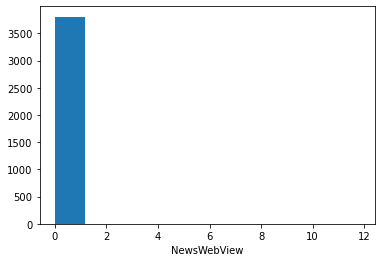

In [235]:
plt.hist(NewsWeb1['NewsWebView'])
plt.xlabel('NewsWebView')
plt.show()

In [236]:
NewsWeb1['NewsWebView'].mean() + NewsWeb1['NewsWebView'].std()

0.21306955812433992

In [243]:
NewsWebView = """
    with t1 as (
            select  
                NewsWebView
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where NewsWebView < 0.21306955812433992
            ) 
    
    )
    select 
        *
    from t1

    """


NewsWeb2 = sqldf(NewsWebView)

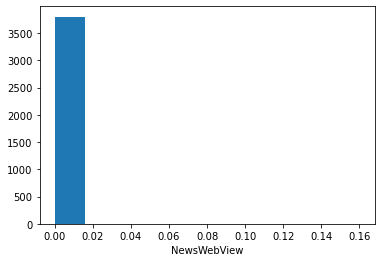

In [239]:
plt.hist(NewsWeb2['NewsWebView'])
plt.xlabel('NewsWebView')
plt.show()

In [103]:
NewsWebView = sqldf("""
            select 
                count(distinct secCode) secCode_count
                , (count(distinct secCode)*1.0)/(select count(distinct secCode) from new_df) as Percent_NewsWebView
            from secCode_by_Time
            where BestPracticesView  < 0.02
            """)
NewsWebView

,secCode_count,Percent_NewsWebView
0,3749,0.983473


In [ ]:
jupyter nbconvert Financial_App.ipynb --to slides --post serve

# Analysis of TipsView

In [ ]:
TipsView : 15680.206174336647 mean : 402.55276388707983

In [255]:
402.55276388707983 + 15680.206174336647

16082.758938223726

In [300]:
TipsView = """
    with t1 as (
            select  
                TipsView
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where TipsView < 5
            ) 
    
    )
    select 
        *
    from t1

    """


Tips1 = sqldf(TipsView)


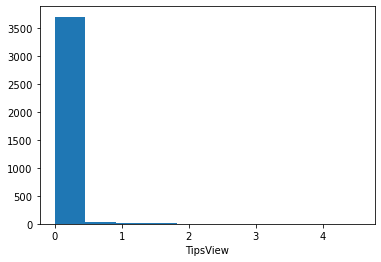

In [301]:
plt.hist(Tips1['TipsView'])
plt.xlabel('TipsView')
plt.show()

In [302]:
Tips1['TipsView'].mean() + Tips1['TipsView'].std()

0.233206291385462

In [35]:
TipsView = """
    with t1 as (
            select  
                TipsView
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where TipsView < 0.233206291385462
            ) 
    
    )
    select 
        *
    from t1

    """


Tips2 = sqldf(TipsView)

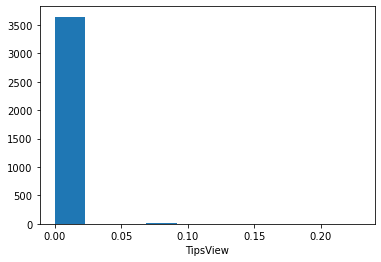

In [33]:
plt.hist(Tips2['TipsView'])
plt.xlabel('TipsView')
plt.savefig('Tipsview{0}.jpg'.format(i))
plt.show()

In [36]:
TipsView = sqldf("""
            select 
                count(distinct secCode) secCode_count
                , (count(distinct secCode)*1.0)/(select count(distinct secCode) from new_df) as Percent_TipsView
            from secCode_by_Time
            where TipsView  < 0.233206291385462
            """)
TipsView

,secCode_count,Percent_TipsView
0,3683,0.966159


# Analysis of ChartsView

In [307]:
#ChartsView : 1187.2585451420657 mean : 42.73206170564517

In [309]:
1187.2585451420657 + 42.73206170564517

1229.990606847711

In [598]:
ChartsView = """
    with t1 as (
            select  
                ChartsView
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where ChartsView < 0.2
            ) 
    
    )
    select 
        *
    from t1

    """


Charts1 = sqldf(ChartsView)

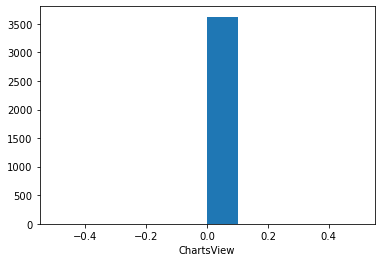

In [599]:
plt.hist(Charts1['ChartsView'])
plt.xlabel('ChartsView')
plt.show()

In [326]:
ChartsView = sqldf("""
            select 
                count(distinct secCode) secCode_count
                , (count(distinct secCode)*1.0)/(select count(distinct secCode) from new_df) as Percent_ChartsView
            from secCode_individual_view_count
            where ChartsView  < 1.0
            """)
ChartsView

,secCode_count,Percent_ChartsView
0,3623,0.95042


# Analysis of GuideScorecardView

In [ ]:
GuideScorecardView : 59628.891487628156 mean : 2943.8222404766957

In [337]:
GuideScorecardView = """
    with t1 as (
            select  
                GuideScorecardView
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where GuideScorecardView < 60
            ) 
    
    )
    select 
        *
    from t1

    """


GuideScorecard1 = sqldf(GuideScorecardView)

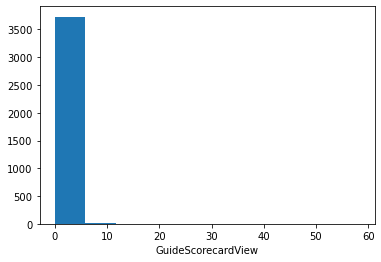

In [338]:
plt.hist(GuideScorecard1['GuideScorecardView'])
plt.xlabel('GuideScorecardView')
plt.show()

In [344]:
GuideScorecard1['GuideScorecardView'].mean() + GuideScorecard1['GuideScorecardView'].std()

2.559291352977595

In [18]:
GuideScorecardView = """
    with t1 as (
            select  
                GuideScorecardView
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where GuideScorecardView < 2.559291352977595
            ) 
    
    )
    select 
        *
    from t1

    """


GuideScorecard2 = sqldf(GuideScorecardView)

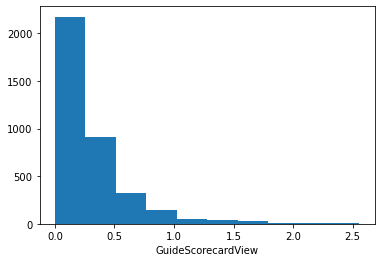

In [19]:
plt.hist(GuideScorecard2['GuideScorecardView'])
plt.xlabel('GuideScorecardView')
plt.savefig('guidescorecardview{0}.jpg'.format(i))

plt.show()

In [347]:
GuideScorecardView = sqldf("""
            select 
                count(distinct secCode) secCode_count
                , (count(distinct secCode)*1.0)/(select count(distinct secCode) from new_df) as Percent_GuideScorecardView
            from secCode_individual_view_count
            where GuideScorecardView  <  2.559291352977595

            """)
GuideScorecardView

,secCode_count,Percent_GuideScorecardView
0,3469,0.910021


# Analysis of GuideSDFView 

In [ ]:
GuideSDFView : 30861.662026871625 mean : 1403.419037654459

In [26]:
GuideSDFView = """
    with t1 as (
            select  
                GuideSDFView
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where GuideSDFView < 90
            ) 
    
    )
    select 
        *
    from t1

    """


GuideSDF1 = sqldf(GuideSDFView)

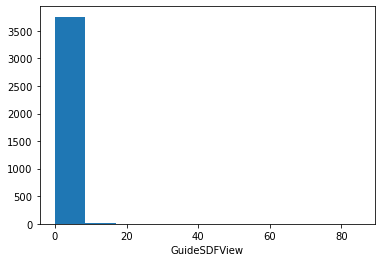

In [27]:
plt.hist(GuideSDF1['GuideSDFView'])
plt.xlabel('GuideSDFView')

plt.savefig('guidesdfview{0}.jpg'.format(i))
plt.show()

In [387]:
GuideSDF1['GuideSDFView'].mean() + GuideSDF1['GuideSDFView'].std()

3.044082618602533

In [21]:
GuideSDFView = """
    with t1 as (
            select  
                GuideSDFView
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where GuideSDFView < 3.044082618602533
            ) 
    
    )
    select 
        *
    from t1

    """


GuideSDF2 = sqldf(GuideSDFView)

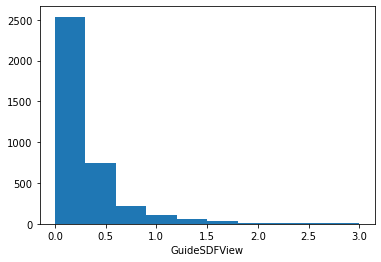

In [28]:
plt.hist(GuideSDF2['GuideSDFView'])
plt.xlabel('GuideSDFView')
plt.savefig('guidesdfview{0}.jpg'.format(i))
plt.show()

In [24]:
GuideSDFView = sqldf("""
            select 
                count(distinct secCode) secCode_count
                , (count(distinct secCode)*1.0)/(select count(distinct secCode) from new_df) as Percent_GuideSDFView
            from secCode_by_Time
            where GuideSDFView  < 3.044082618602533

            """)
GuideSDFView

,secCode_count,Percent_GuideSDFView
0,3729,0.978227


# Analysis of GuideZoneChangesView 

In [ ]:
GuideZoneChangesView : 39369.835043916246 mean : 2049.9337505227218

In [418]:
GuideZoneChangesView = """
    with t1 as (
            select  
                GuideZoneChangesView
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where GuideZoneChangesView < 40
            ) 
    
    )
    select 
        *
    from t1

    """


GuideZoneChanges1 = sqldf(GuideZoneChangesView)

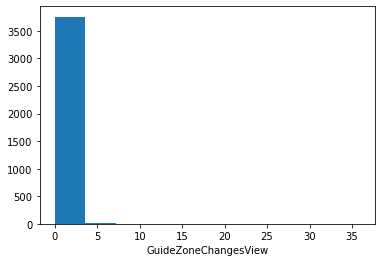

In [419]:
plt.hist(GuideZoneChanges1['GuideZoneChangesView'])
plt.xlabel('GuideZoneChangesView')
plt.show()

In [420]:
GuideZoneChanges1['GuideZoneChangesView'].mean() + GuideZoneChanges1['GuideZoneChangesView'].std()

1.2091240367562877

In [30]:
GuideZoneChangesView = """
    with t1 as (
            select  
                GuideZoneChangesView
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where GuideZoneChangesView < 1.2091240367562877
            ) 
    
    )
    select 
        *
    from t1

    """


GuideZoneChanges2 = sqldf(GuideZoneChangesView)

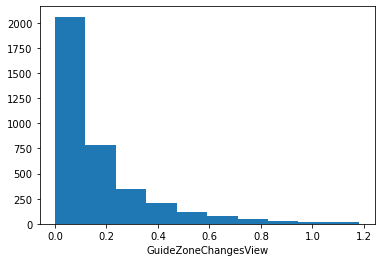

In [31]:
plt.hist(GuideZoneChanges2['GuideZoneChangesView'])
plt.xlabel('GuideZoneChangesView')
plt.savefig('guideZonechangeview{0}.jpg'.format(i))
plt.show()

In [424]:
GuideZoneChangesView = sqldf("""
            select 
                count(distinct secCode) secCode_count
                , (count(distinct secCode)*1.0)/(select count(distinct secCode) from new_df) as Percent_GuideZoneChangesView
            from secCode_individual_view_count
            where GuideZoneChangesView  < 1.2091240367562877

            """)
GuideZoneChangesView

,secCode_count,Percent_GuideZoneChangesView
0,3044,0.798531


# Analysis of GuideTipsView

In [ ]:
GuideTipsView : 20313.62462099769 mean : 900.0132142715651

In [432]:
GuideTipsView = """
    with t1 as (
            select  
                GuideTipsView
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where GuideTipsView < 2
            ) 
    
    )
    select 
        *
    from t1

    """


GuideTips1 = sqldf(GuideTipsView)

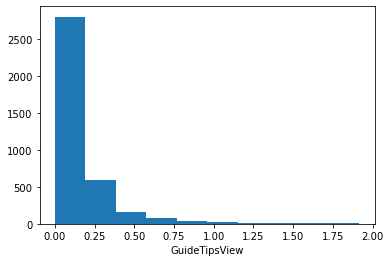

In [433]:
plt.hist(GuideTips1['GuideTipsView'])
plt.xlabel('GuideTipsView')

plt.show()

In [437]:
GuideTipsView = sqldf("""
            select 
                count(distinct secCode) secCode_count
                , (count(distinct secCode)*1.0)/(select count(distinct secCode) from new_df) as Percent_GuideTipsView
            from secCode_individual_view_count
            where GuideTipsView  < 2.0 

            """)
GuideTipsView

,secCode_count,Percent_GuideTipsView
0,3075,0.806663


# Analysis of GuideEmailView

In [ ]:
GuideEmailView : 58064.29501110795 mean : 2741.2854505076507

In [444]:
GuideEmailView = """
    with t1 as (
            select  
                GuideEmailView
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where GuideEmailView < 3
            ) 
    
    )
    select 
        *
    from t1

    """


GuideEmail1 = sqldf(GuideEmailView)

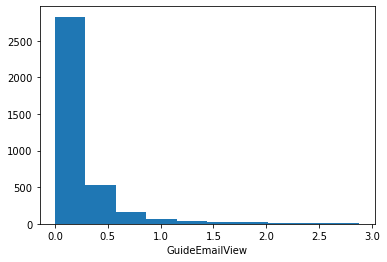

In [445]:
plt.hist(GuideEmail1['GuideEmailView'])
plt.xlabel('GuideEmailView')
plt.show()

In [447]:
GuideEmailView = sqldf("""
            select 
                count(distinct secCode) secCode_count
                , (count(distinct secCode)*1.0)/(select count(distinct secCode) from new_df) as Percent_GuideTipsView
            from secCode_individual_view_count
            where GuideEmailView < 3.0 

            """)
GuideEmailView

,secCode_count,Percent_GuideTipsView
0,3398,0.891396


# Analysis of GuidePushView

In [ ]:
GuidePushView : 7981.171399548687 mean : 342.1930332456129

In [460]:
GuidePushView = """
    with t1 as (
            select  
                GuidePushView
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where GuidePushView < 2.0
            ) 
    
    )
    select 
        *
    from t1

    """


GuidePush1 = sqldf(GuidePushView)

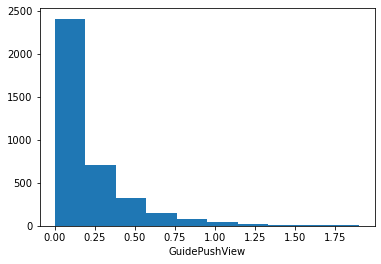

In [461]:
plt.hist(GuidePush1['GuidePushView'])
plt.xlabel('GuidePushView')
plt.show()

In [462]:
GuidePushView = sqldf("""
            select 
                count(distinct secCode) secCode_count
                , (count(distinct secCode)*1.0)/(select count(distinct secCode) from new_df) as Percent_GuidePushView
            from secCode_individual_view_count
            where GuidePushView < 2.0 

            """)
GuidePushView

,secCode_count,Percent_GuidePushView
0,3132,0.821616


# Analysis of InfoView

In [ ]:
InfoView : 29064.259780644326 mean : 2570.6807777158697

In [480]:
InfoView = """
    with t1 as (
            select  
                InfoView
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where InfoView < 3
            ) 
    
    )
    select 
        *
    from t1

    """


Info1 = sqldf(InfoView)

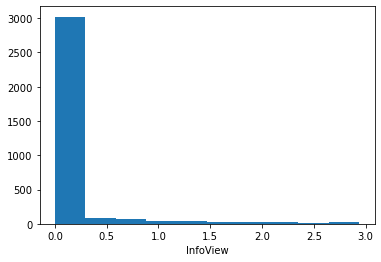

In [484]:
plt.hist(Info1['InfoView'])
plt.xlabel('InfoView')
plt.show()

In [39]:
InfoView = sqldf("""
            select 
                count(distinct secCode) secCode_count
                , (count(distinct secCode)*1.0)/(select count(distinct secCode) from new_df) as Percent_GuidePushView
            from secCode_by_Time 
            where InfoView < 3 

            """)
InfoView

,secCode_count,Percent_GuidePushView
0,3404,0.89297


# Analysis of ScorecardView

In [ ]:
ScorecardView : 17901.58977169055 mean : 1529.9171912623694

In [507]:
ScorecardView = """
    with t1 as (
            select  
                ScorecardView
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where ScorecardView < 3
            ) 
    
    )
    select 
        *
    from t1

    """


Scorecard1 = sqldf(ScorecardView)

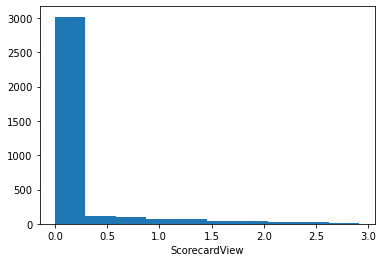

In [508]:
plt.hist(Scorecard1['ScorecardView'])
plt.xlabel('ScorecardView')
plt.show()

In [509]:
ScorecardView = sqldf("""
            select 
                count(distinct secCode) secCode_count
                , (count(distinct secCode)*1.0)/(select count(distinct secCode) from new_df) as Percent_ScorecardView
            from secCode_individual_view_count
            where ScorecardView < 3 

            """)
ScorecardView

,secCode_count,Percent_ScorecardView
0,3551,0.931532


# Analysis of TickerView

In [ ]:
TickerView : 12972.07268297125 mean : 727.8478866960663

In [528]:
TickerView = """
    with t1 as (
            select  
                TickerView
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where TickerView < 2.5
            ) 
    
    )
    select 
        *
    from t1

    """


Ticker1 = sqldf(TickerView)

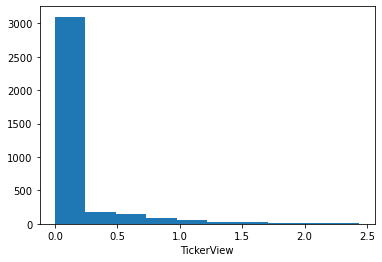

In [529]:
plt.hist(Ticker1['TickerView'])
plt.xlabel('TickerView')
plt.show()

In [530]:
TickerView = sqldf("""
            select 
                count(distinct secCode) secCode_count
                , (count(distinct secCode)*1.0)/(select count(distinct secCode) from new_df) as Percent_TickerView
            from secCode_individual_view_count
            where TickerView < 2.5 

            """)
TickerView

,secCode_count,Percent_TickerView
0,3611,0.947272


# Analysis of CouldaView

In [ ]:
CouldaView : 28190.85516690938 mean : 1258.0060763864574

In [539]:
CouldaView = """
    with t1 as (
            select  
                CouldaView
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where CouldaView < 2
            ) 
    
    )
    select 
        *
    from t1

    """


Coulda1 = sqldf(CouldaView)

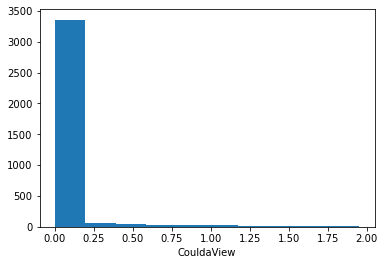

In [540]:
plt.hist(Coulda1['CouldaView'])
plt.xlabel('CouldaView')
plt.show()

In [552]:
CouldaView = sqldf("""
            select 
                count(distinct secCode) secCode_count
                , (count(distinct secCode)*1.0)/(select count(distinct secCode) from new_df) as Percent_CouldaView
            from secCode_individual_view_count
            where CouldaView < 2 

            """)
CouldaView

,secCode_count,Percent_CouldaView
0,3545,0.929958


# Analysis of ZoneChangesView

In [ ]:
ZoneChangesView : 16976.876395101746 mean : 1135.3159484190005

In [570]:
ZoneChangesView = """
    with t1 as (
            select  
                ZoneChangesView
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where ZoneChangesView < 1
            ) 
    
    )
    select 
        *
    from t1

    """


ZoneChanges1 = sqldf(ZoneChangesView)

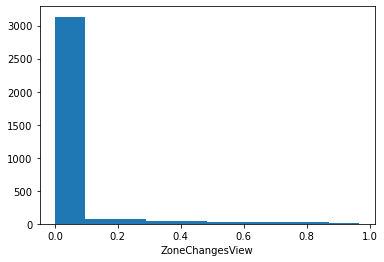

In [574]:
plt.hist(ZoneChanges1['ZoneChangesView'])
plt.xlabel('ZoneChangesView')
plt.show()

In [60]:
ZoneChangesView = sqldf("""
            select 
                count(distinct secCode) secCode_count
                , (count(distinct secCode)*1.0)/(select count(distinct secCode) from new_df) as Percent_ZoneChangesView
            from secCode_by_Time
            where ZoneChangesView < 1.0

            """)
ZoneChangesView

,secCode_count,Percent_ZoneChangesView
0,3488,0.915005


# Analysis of TipView

In [ ]:
TipView : 20211.139606731784 mean : 1251.2090773769498

In [55]:
TipsView = """
    with t1 as (
            select  
                TipsView 
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where TipsView  < 2
            ) 
    
    )
    select 
        *
    from t1

    """
Tip1 = sqldf(TipsView )

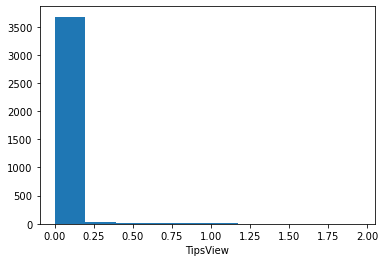

In [56]:
plt.hist(Tip1['TipsView'])
plt.xlabel('TipsView')
plt.show()

In [57]:
TipView = sqldf("""
            select 
                count(distinct secCode) secCode_count
                , (count(distinct secCode)*1.0)/(select count(distinct secCode) from new_df) as Percent_TipView
            from secCode_by_Time
            where TipsView < 1.0

            """)
TipView

,secCode_count,Percent_TipView
0,3738,0.980588


In [581]:
Tip1['TipView'].mean() + Tip1['TipView'].std()

0.23533245258750302

In [584]:
TipView = """
    with t1 as (
            select  
                TipView 
            from secCode_by_Time ST
            where ST.secCode in
            (select 
                distinct secCode as secCode
            from secCode_by_Time 
            where TipView  < 0.23533245258750302
            ) 
    
    )
    select 
        *
    from t1

    """
Tip2 = sqldf(TipView )

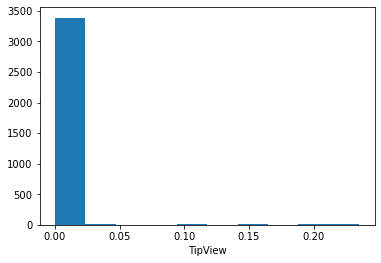

In [585]:
plt.hist(Tip2['TipView'])
plt.xlabel('TipView')
plt.show()

In [59]:
TipView = sqldf("""
            select 
                count(distinct secCode) secCode_count
                , (count(distinct secCode)*1.0)/(select count(distinct secCode) from new_df) as Percent_TipView
            from secCode_by_Time
            where TipsView < 0.23533245258750302
            """)
TipView

,secCode_count,Percent_TipView
0,3683,0.966159


# Dataframe without outliers

In [154]:
Data_without_outlier = sqldf("""
            select 
                count(distinct secCode) secCode_count
                , (count(distinct secCode)*1.0)/(select count(distinct secCode) from new_df) as Percent_Total
            from secCode_by_Time
            where DashboardView  < 11.0
                and GuideView  < 6.0
                and GuideScorecardView  <  3.0
                and GuidePushView < 2.0
                and TipsView < 0.23533245258750302
                and TickerView < 2.5 
                and CouldaView < 2.0
                and ZoneChangesView < 1.0
                and IPadContainerView < 3.0
                and GuideTipsView  < 2.0 
                and GuideEmailView < 3.0 
                and InfoView < 3 
                and ScorecardView < 3  
        

            """)
Data_without_outlier

,secCode_count,Percent_Total
0,1540,0.403987


In [163]:
new_df2 = sqldf("""
            select * 
            from new_df 
            where secCode in (
                    select 
                        distinct secCode
                    from secCode_by_Time
                    where DashboardView  < 11.0
                        and GuideView  < 6.0
                        and GuideScorecardView  <  3.0
                        and GuideZoneChangesView  < 1.5
                        and GuidePushView < 3.0
                        and TipsView <  3.0
                        and TickerView < 3 
                        and CouldaView < 3.0
                        and ZoneChangesView < 3.0
                        and IPadContainerView < 3.0
                        and GuideSDFView < 3.0
                        and GuideTipsView  < 2.0 
                        and GuideEmailView < 3.0 
                        and InfoView < 3
                        and ScorecardView < 3 
                        
                            )
            """)

new_df2

,id,secCode,view,action,detail,transactions,url,articleId,movie,promoCode,isSubscribed,timestamp,activity_order,lead_ts,lastSubscrib,last_act,Sec_length,time_spent
0,27604,003EBB85-46C9-4A3A-9834-96241A5D8782,DashboardViewController,viewWillAppear,none,,,,,,N,2020-06-21 05:16:39,1,2020-06-21 05:16:39,N,1,0.0,0
1,27605,003EBB85-46C9-4A3A-9834-96241A5D8782,GuideViewController,guideViewWillAppear,none,,,,,,N,2020-06-21 05:16:39,2,2020-06-21 05:16:44,N,1,5.0,1
2,27606,003EBB85-46C9-4A3A-9834-96241A5D8782,GuideViewController,whatsNew,none,,,,,,N,2020-06-21 05:16:44,3,2020-06-21 05:16:47,N,1,3.0,1
3,27607,003EBB85-46C9-4A3A-9834-96241A5D8782,GuideViewController,whatsNew,none,,,,,,N,2020-06-21 05:16:47,4,2020-06-21 05:16:52,N,1,5.0,1
4,27608,003EBB85-46C9-4A3A-9834-96241A5D8782,GuideScorecardViewController,guideViewWillAppear,none,,,,,,N,2020-06-21 05:16:52,5,2020-06-21 05:17:00,N,1,8.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18736,87652,FFF6F9B6-4233-4A36-93EE-157B6BCE0C19,GuideViewController,guideViewWillAppear,none,,,,,,N,2021-04-01 11:02:12,2,2021-04-01 11:02:13,N,1,1.0,1
18737,87653,FFF6F9B6-4233-4A36-93EE-157B6BCE0C19,DashboardViewController,viewWillAppear,none,,,,,,N,2021-04-01 11:02:13,3,2021-04-01 11:02:14,N,1,1.0,1
18738,87654,FFF6F9B6-4233-4A36-93EE-157B6BCE0C19,GuideViewController,guideViewWillAppear,none,,,,,,N,2021-04-01 11:02:14,4,2021-04-01 11:02:18,N,1,4.0,1
18739,87655,FFF6F9B6-4233-4A36-93EE-157B6BCE0C19,GuideViewController,whatsNew,none,,,,,,N,2021-04-01 11:02:18,5,2021-04-01 11:02:29,N,1,11.0,1


In [164]:
#number of feature views for subscribed viewers for normal distributed 

q  = """
    select 
        view 
        , count(*)
    from new_df2
    where lastSubscrib = 'Y'
    group by 1
    order by 2 desc
    
    """

sqldf(q)


unsubscribed_view_count = sqldf(q)
unsubscribed_view_count

,view,count(*)
0,DashboardViewController,180
1,SubscriptionViewController,107
2,GuideViewController,62
3,ScorecardViewController,56
4,InfoViewController,56
5,GuideEmailViewController,34
6,GuideZoneChangesViewController,31
7,GuidePushViewController,31
8,GuideTipsViewController,30
9,GuideScorecardViewController,30


In [165]:
q = """
    with t1 as(
            select 
                secCode
                , round(avg(case when view = 'DashboardViewController' then sec_length else 0 
                    end), 2) as DashboardView 
                , round(avg(case when view = 'BestPracticesViewController' then sec_length else 0 
                    end), 2) as BestPracticesView
                , round(avg(case when view = 'NewsWebViewController' then sec_length else 0 
                    end), 2) as NewsWebView
                , avg(case when view = 'TipsViewController' then sec_length else 0 
                    end) as TipsView
                , avg(case when view = 'ChartsViewController' then sec_length else 0 
                    end) as ChartsView       
                , avg(case when view = 'IPadContainerViewController' then sec_length else 0 
                    end) as IPadContainerView  
                , avg(case when view = 'GuideViewController' then sec_length else 0 
                    end) as GuideView
                , avg(case when view = 'GuideScorecardViewController' then sec_length else 0 
                    end) as GuideScorecardView
                , avg(case when view = 'GuideSDFViewController' then sec_length else 0 
                    end) as GuideSDFView
                , avg(case when view = 'GuideZoneChangesViewController' then sec_length else 0 
                    end) as GuideZoneChangesView
                , avg(case when view = 'GuideTipsViewController' then sec_length else 0 
                    end) as GuideTipsView
                , avg(case when view = 'GuideEmailViewController' then sec_length else 0 
                    end) as GuideEmailView
                , avg(case when view = 'GuidePushViewController' then sec_length else 0 
                    end) as GuidePushView
                , avg(case when view = 'InfoViewController' then sec_length else 0 
                    end) as InfoView
                , avg(case when view = 'ScorecardViewController' then sec_length else 0 
                    end) as ScorecardView
                , avg(case when view = 'TickerViewController' then sec_length else 0 
                    end) as TickerView
                , avg(case when view = 'CouldaViewController' then sec_length else 0 
                    end) as CouldaView
                , avg(case when view = 'ZoneChangesViewController' then sec_length else 0 
                    end) as ZoneChangesView
                , avg(case when view = 'CouldaViewController' then sec_length else 0 
                    end) as CouldaView
                , avg(case when view = 'NewsAddViewController' then sec_length else 0 
                    end) as NewsAddView
                , avg(case when view = 'SettingsViewController' then sec_length else 0 
                    end) as SettingsView    
           
            from new_df2
            group by 1
            order by 2 desc
            )
        
    select 
        *
    from t1
    
    
    """

sqldf(q)


secCode_by_Time_newdf= sqldf(q)
secCode_by_Time_newdf.head(1)

,secCode,DashboardView,BestPracticesView,NewsWebView,TipsView,ChartsView,IPadContainerView,GuideView,GuideScorecardView,GuideSDFView,...,GuideEmailView,GuidePushView,InfoView,ScorecardView,TickerView,CouldaView,ZoneChangesView,CouldaView:1,NewsAddView,SettingsView
0,0582BBC9-25BA-4B0E-AFB0-5DD96D4BAC02,10.67,0.0,0.0,0.0,0.0,0.0,0.533333,0.2,0.066667,...,0.2,0.133333,0.0,1.4,0.0,0.0,1.266667,0.0,0.0,0.0


In [166]:
average_view_time = sqldf("""
        select 
             avg(DashboardView) as avg_Dashboard
            , avg(BestPracticesView) as avg_BestPractices
            , avg(NewsWebView) as avg_NewsWeb
            , avg(TipsView) as avg_Tips
            , avg(IPadContainerView) as avg_IPaadcontainer
            , avg(GuideView) as avg_GuideView
            , avg(GuideScorecardView) as avg_GuideScorecard
            , avg(GuideSDFView) as avg_GuideSDF
            , avg(GuideZoneChangesView) as avg_GuideZonechanges
            , avg(GuidePushView) as avg_GuidePush
            , avg(InfoView) as avg_Info
            , avg(ScorecardView) as avg_Scorecard
            , avg(TickerView) as avg_Ticker
            , avg(CouldaView) as avg_Coulda
            , avg(ZoneChangesView) as avg_ZoneChange
        from secCode_by_Time_newdf

""")

average_view_time

,avg_Dashboard,avg_BestPractices,avg_NewsWeb,avg_Tips,avg_IPaadcontainer,avg_GuideView,avg_GuideScorecard,avg_GuideSDF,avg_GuideZonechanges,avg_GuidePush,avg_Info,avg_Scorecard,avg_Ticker,avg_Coulda,avg_ZoneChange
0,1.574618,0.002075,0.008414,0.012676,0.007603,0.699075,0.321568,0.285564,0.18121,0.204872,0.11952,0.14999,0.115264,0.052786,0.058918


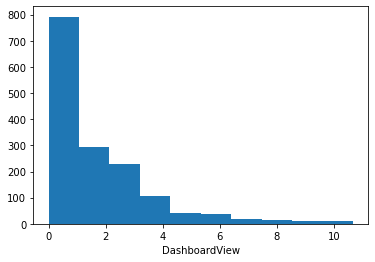

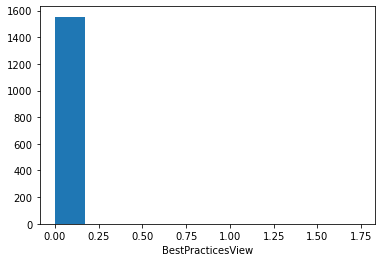

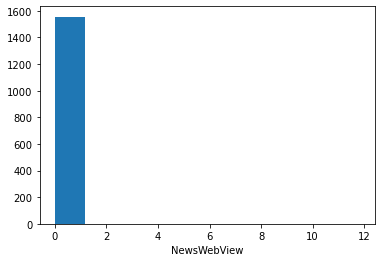

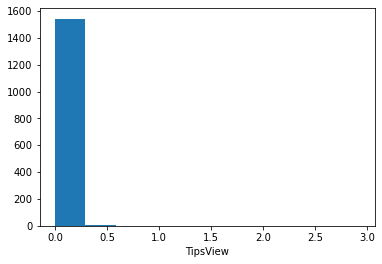

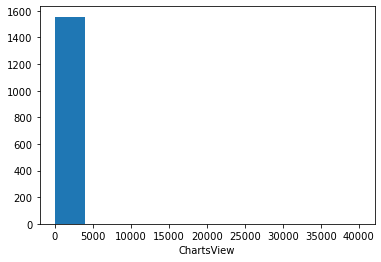

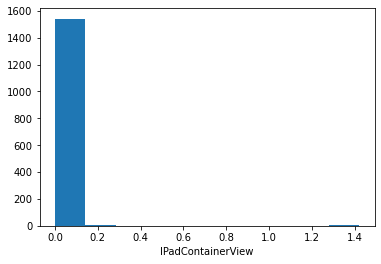

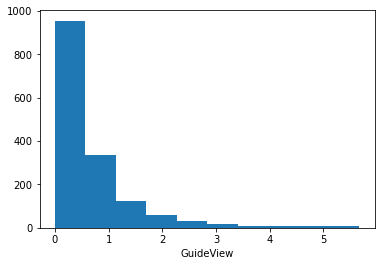

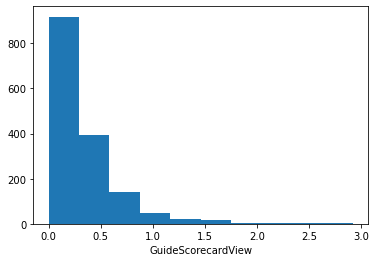

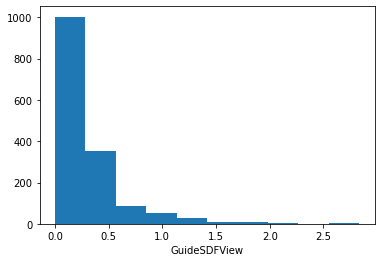

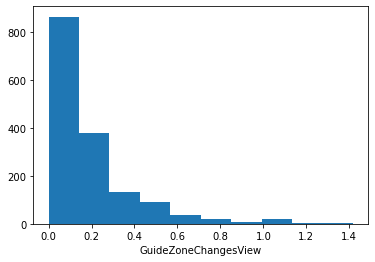

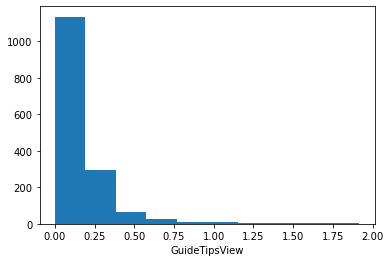

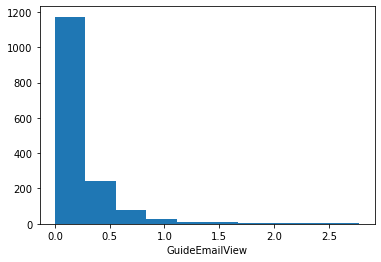

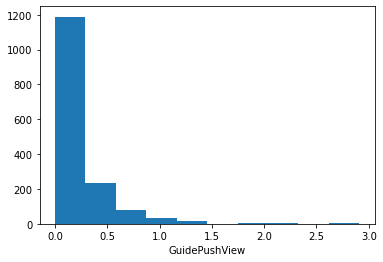

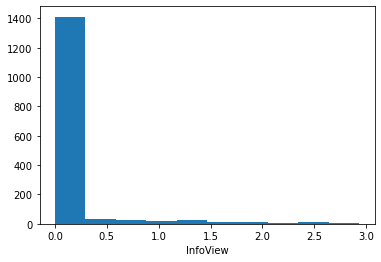

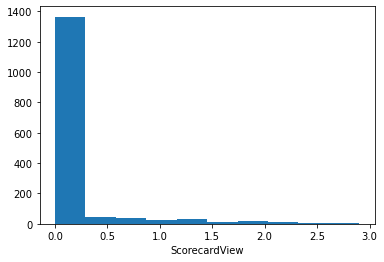

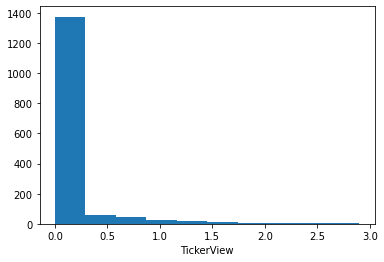

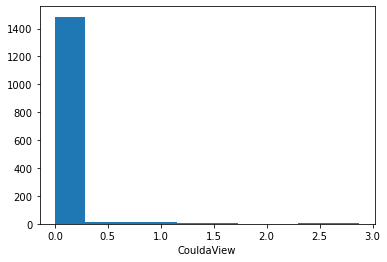

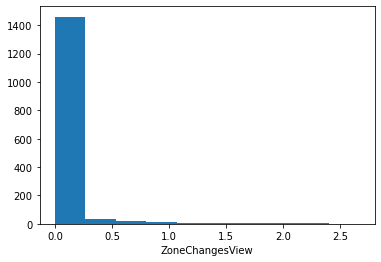

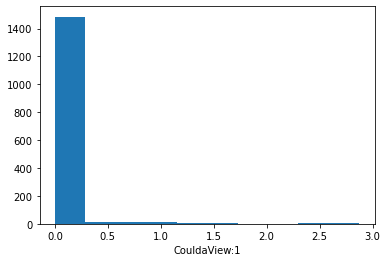

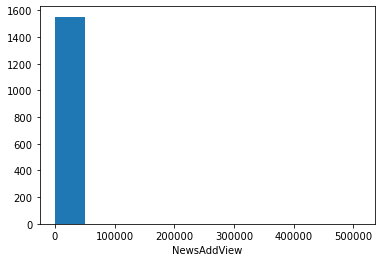

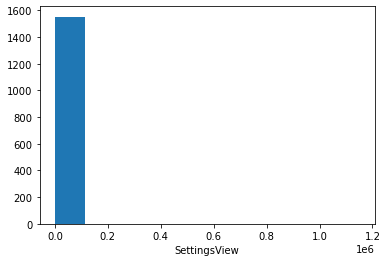

In [167]:
X = secCode_by_Time_newdf.drop('secCode', axis= 1)

for i in X:
    plt.figure(i)
    plt.hist(X[i])
    plt.xlabel(i)
    #plt.savefig('sub30 {0}.jpg'.format(i))
    #plt.close()
    plt.show()

In [172]:
#subscribed users that are trully using the app
sqldf("""
select count(distinct secCode) Real_users
from new_df2
where lastSubscrib = 'Y'
""")

,Real_users
0,27


In [173]:
#users that could be converted to subscribed users
sqldf("""
select count(distinct secCode) Real_users
from new_df2
where lastSubscrib != 'Y'
""")

,Real_users
0,1530


In [174]:
# averaget time a subscribed user spends on the app
q = """
    with t1 as(
        select *
        from new_df2
        where lastSubscrib = 'Y'
    ),
    t2 as 
            (
            select 
                secCode
                , round(avg(case when view = 'DashboardViewController' then sec_length else 0 
                    end), 2) as DashboardView 
                , round(avg(case when view = 'BestPracticesViewController' then sec_length else 0 
                    end), 2) as BestPracticesView
                , round(avg(case when view = 'NewsWebViewController' then sec_length else 0 
                    end), 2) as NewsWebView
                , avg(case when view = 'TipsViewController' then sec_length else 0 
                    end) as TipsView
                , avg(case when view = 'ChartsViewController' then sec_length else 0 
                    end) as ChartsView       
                , avg(case when view = 'IPadContainerViewController' then sec_length else 0 
                    end) as IPadContainerView  
                , avg(case when view = 'GuideViewController' then sec_length else 0 
                    end) as GuideView
                , avg(case when view = 'GuideScorecardViewController' then sec_length else 0 
                    end) as GuideScorecardView
                , avg(case when view = 'GuideSDFViewController' then sec_length else 0 
                    end) as GuideSDFView
                , avg(case when view = 'GuideZoneChangesViewController' then sec_length else 0 
                    end) as GuideZoneChangesView
                , avg(case when view = 'GuideTipsViewController' then sec_length else 0 
                    end) as GuideTipsView
                , avg(case when view = 'GuideEmailViewController' then sec_length else 0 
                    end) as GuideEmailView
                , avg(case when view = 'GuidePushViewController' then sec_length else 0 
                    end) as GuidePushView
                , avg(case when view = 'InfoViewController' then sec_length else 0 
                    end) as InfoView
                , avg(case when view = 'ScorecardViewController' then sec_length else 0 
                    end) as ScorecardView
                , avg(case when view = 'TickerViewController' then sec_length else 0 
                    end) as TickerView
                , avg(case when view = 'CouldaViewController' then sec_length else 0 
                    end) as CouldaView
                , avg(case when view = 'ZoneChangesViewController' then sec_length else 0 
                    end) as ZoneChangesView
                , avg(case when view = 'CouldaViewController' then sec_length else 0 
                    end) as CouldaView
                , avg(case when view = 'NewsAddViewController' then sec_length else 0 
                    end) as NewsAddView
                , avg(case when view = 'SettingsViewController' then sec_length else 0 
                    end) as SettingsView    
           
            from t1
            group by 1
            order by 2 desc
            )
    select 
        *
    from t2
    order by 2 desc
    
    """

subscribed_avg_time_secCode = sqldf(q)
subscribed_avg_time_secCode

,secCode,DashboardView,BestPracticesView,NewsWebView,TipsView,ChartsView,IPadContainerView,GuideView,GuideScorecardView,GuideSDFView,...,GuideEmailView,GuidePushView,InfoView,ScorecardView,TickerView,CouldaView,ZoneChangesView,CouldaView:1,NewsAddView,SettingsView
0,61C39E38-4A52-493D-BF35-AF555CC998DB,8.50,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,6268A2D0-8FDE-40A4-B0CC-C3D15C565559,7.34,0.0,0.0,0.000000,0.642857,0.00000,0.309524,0.214286,0.404762,...,0.190476,0.071429,0.452381,1.809524,0.285714,0.000000,0.000000,0.000000,0.000000,0.000000
2,A34DD05B-5C9F-43CD-B04A-DA3051882683,7.13,0.0,0.0,0.000000,0.625000,0.00000,0.250000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.500000,0.000000,7.875000
3,1847D657-2E3C-46CC-8B44-10B8F652C8A7,4.36,0.0,0.0,0.000000,0.000000,0.00000,0.230769,0.038462,0.038462,...,0.038462,0.038462,2.115385,0.730769,1.769231,0.000000,0.192308,0.000000,0.000000,0.615385
4,FFC18754-A253-47E5-AB2F-0D30255229EE,4.12,0.0,0.0,0.000000,0.000000,0.00000,0.461538,0.307692,0.615385,...,0.500000,0.692308,0.653846,2.192308,0.846154,0.000000,0.000000,0.000000,0.000000,0.000000
5,0EEB24FF-7E6D-4784-80E2-3687E1F64A2F,4.00,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,26480B7F-C8FD-4411-83B8-77E613F94D7D,3.77,0.0,0.0,0.000000,0.000000,0.00000,0.600000,0.250000,0.175000,...,0.150000,0.675000,0.200000,0.350000,2.900000,1.175000,1.525000,1.175000,0.000000,0.000000
7,1720C271-9385-41DF-99E2-133D63014A49,3.50,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,B7B0168D-FE69-41B8-9263-2BC3CE9CE15B,3.34,0.0,0.0,0.000000,0.085714,0.00000,1.485714,0.028571,0.114286,...,0.028571,0.028571,2.228571,0.676471,0.000000,0.371429,0.257143,0.371429,0.000000,0.342857
9,8BC8D437-DEC7-4E9D-9824-09B4BAEE7E43,3.03,0.0,0.0,0.000000,0.000000,0.00000,0.333333,0.102564,0.076923,...,0.025641,0.051282,0.102564,2.615385,0.000000,0.000000,0.410256,0.000000,0.000000,0.000000


In [177]:
average_view_time_subs = sqldf("""
        select 
             avg(DashboardView) as avg_Dashboard
            , avg(BestPracticesView) as avg_BestPractices
            , avg(NewsWebView) as avg_NewsWeb
            , avg(TipsView) as avg_Tips
            , avg(IPadContainerView) as avg_IPaadcontainer
            , avg(GuideView) as avg_GuideView
            , avg(GuideScorecardView) as avg_GuideScorecard
            , avg(GuideSDFView) as avg_GuideSDF
            , avg(GuideZoneChangesView) as avg_GuideZonechanges
            , avg(GuidePushView) as avg_GuidePush
            , avg(InfoView) as avg_Info
            , avg(ScorecardView) as avg_Scorecard
            , avg(TickerView) as avg_Ticker
            , avg(CouldaView) as avg_Coulda
            , avg(ZoneChangesView) as avg_ZoneChange
        from subscribed_avg_time_secCode

""")

average_view_time_subs

,avg_Dashboard,avg_BestPractices,avg_NewsWeb,avg_Tips,avg_IPaadcontainer,avg_GuideView,avg_GuideScorecard,avg_GuideSDF,avg_GuideZonechanges,avg_GuidePush,avg_Info,avg_Scorecard,avg_Ticker,avg_Coulda,avg_ZoneChange
0,2.696667,0.0,0.0,0.011785,0.005904,0.371192,0.112162,0.121232,0.099619,0.168993,0.50066,0.654033,0.489955,0.291652,0.276205


In [179]:
q = """
    with t1 as(
        select *
        from new_df2
        where lastSubscrib != 'Y'
    ),
    t2 as 
            (
            select 
                secCode
                , round(avg(case when view = 'DashboardViewController' then sec_length else 0 
                    end), 2) as DashboardView 
                , round(avg(case when view = 'BestPracticesViewController' then sec_length else 0 
                    end), 2) as BestPracticesView
                , round(avg(case when view = 'NewsWebViewController' then sec_length else 0 
                    end), 2) as NewsWebView
                , avg(case when view = 'TipsViewController' then sec_length else 0 
                    end) as TipsView
                , avg(case when view = 'ChartsViewController' then sec_length else 0 
                    end) as ChartsView       
                , avg(case when view = 'IPadContainerViewController' then sec_length else 0 
                    end) as IPadContainerView  
                , avg(case when view = 'GuideViewController' then sec_length else 0 
                    end) as GuideView
                , avg(case when view = 'GuideScorecardViewController' then sec_length else 0 
                    end) as GuideScorecardView
                , avg(case when view = 'GuideSDFViewController' then sec_length else 0 
                    end) as GuideSDFView
                , avg(case when view = 'GuideZoneChangesViewController' then sec_length else 0 
                    end) as GuideZoneChangesView
                , avg(case when view = 'GuideTipsViewController' then sec_length else 0 
                    end) as GuideTipsView
                , avg(case when view = 'GuideEmailViewController' then sec_length else 0 
                    end) as GuideEmailView
                , avg(case when view = 'GuidePushViewController' then sec_length else 0 
                    end) as GuidePushView
                , avg(case when view = 'InfoViewController' then sec_length else 0 
                    end) as InfoView
                , avg(case when view = 'ScorecardViewController' then sec_length else 0 
                    end) as ScorecardView
                , avg(case when view = 'TickerViewController' then sec_length else 0 
                    end) as TickerView
                , avg(case when view = 'CouldaViewController' then sec_length else 0 
                    end) as CouldaView
                , avg(case when view = 'ZoneChangesViewController' then sec_length else 0 
                    end) as ZoneChangesView
                , avg(case when view = 'CouldaViewController' then sec_length else 0 
                    end) as CouldaView
                , avg(case when view = 'NewsAddViewController' then sec_length else 0 
                    end) as NewsAddView
                , avg(case when view = 'SettingsViewController' then sec_length else 0 
                    end) as SettingsView    
           
            from t1
            group by 1
            order by 2 desc
            )
    select 
        *
    from t2
    order by 2 desc
    
    """

unsubscribed_avg_time_secCode = sqldf(q)
unsubscribed_avg_time_secCode

,secCode,DashboardView,BestPracticesView,NewsWebView,TipsView,ChartsView,IPadContainerView,GuideView,GuideScorecardView,GuideSDFView,...,GuideEmailView,GuidePushView,InfoView,ScorecardView,TickerView,CouldaView,ZoneChangesView,CouldaView:1,NewsAddView,SettingsView
0,0582BBC9-25BA-4B0E-AFB0-5DD96D4BAC02,10.67,0.0,0.0,0.00000,0.0,0.0,0.533333,0.200000,0.066667,...,0.200000,0.133333,0.0000,1.400000,0.000000,0.0,1.266667,0.0,0.0,0.0
1,555D3810-7C28-426B-9303-B30C4D586428,10.56,0.0,0.0,0.00000,0.0,0.0,1.062500,0.437500,0.312500,...,0.250000,0.125000,0.0000,1.625000,0.000000,0.0,0.000000,0.0,0.0,0.0
2,4FFEC489-DCE9-4D5C-9943-8E6305CF3D28,10.47,0.0,0.0,0.00000,0.0,0.0,0.500000,0.444444,0.166667,...,0.055556,0.055556,0.0000,1.111111,1.055556,0.0,1.333333,0.0,0.0,0.0
3,0C9C6B12-76A9-4B88-8C6A-674756A3A230,10.45,0.0,0.0,0.21875,0.0,0.0,0.406250,0.343750,0.375000,...,0.218750,0.125000,0.3125,0.437500,0.718750,0.0,0.000000,0.0,0.0,0.0
4,BA974614-FAC3-49EA-A3A2-6DE1AFAE4253,10.44,0.0,0.0,0.00000,0.0,0.5,0.277778,0.277778,0.111111,...,0.055556,0.055556,0.0000,0.000000,0.000000,0.0,0.111111,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1525,015A09AB-8721-462A-B4FB-9E6AA403C1E6,0.00,0.0,0.0,0.00000,0.0,0.0,0.222222,0.222222,0.111111,...,0.111111,0.222222,0.0000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
1526,0136ED78-D494-4545-AC7D-C79543AFEF63,0.00,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
1527,01207A56-1F2F-40F8-972B-A7323E51BF0F,0.00,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
1528,00AAB63E-EF73-4E9A-A199-0CA178C1C6F0,0.00,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0


In [180]:
average_view_time_unsubs = sqldf("""
        select 
             avg(DashboardView) as avg_Dashboard
            , avg(BestPracticesView) as avg_BestPractices
            , avg(NewsWebView) as avg_NewsWeb
            , avg(TipsView) as avg_Tips
            , avg(IPadContainerView) as avg_IPaadcontainer
            , avg(GuideView) as avg_GuideView
            , avg(GuideScorecardView) as avg_GuideScorecard
            , avg(GuideSDFView) as avg_GuideSDF
            , avg(GuideZoneChangesView) as avg_GuideZonechanges
            , avg(GuidePushView) as avg_GuidePush
            , avg(InfoView) as avg_Info
            , avg(ScorecardView) as avg_Scorecard
            , avg(TickerView) as avg_Ticker
            , avg(CouldaView) as avg_Coulda
            , avg(ZoneChangesView) as avg_ZoneChange
        from unsubscribed_avg_time_secCode

""")

average_view_time_unsubs

,avg_Dashboard,avg_BestPractices,avg_NewsWeb,avg_Tips,avg_IPaadcontainer,avg_GuideView,avg_GuideScorecard,avg_GuideSDF,avg_GuideZonechanges,avg_GuidePush,avg_Info,avg_Scorecard,avg_Ticker,avg_Coulda,avg_ZoneChange
0,1.554817,0.002111,0.008562,0.012692,0.007633,0.704861,0.325263,0.288463,0.18265,0.205505,0.112794,0.141095,0.108652,0.04857,0.055083


In [617]:
q = """
        select * 
        from new_df2
        where secCode = '1DDF0E12-2B5D-4181-83A7-C270804CE1EF'


"""

sqldf(q)

,id,secCode,view,action,detail,transactions,url,articleId,movie,promoCode,isSubscribed,timestamp,activity_order,lead_ts,lastSubscrib,last_act,Sec_length,time_spent
0,55663,1DDF0E12-2B5D-4181-83A7-C270804CE1EF,DashboardViewController,viewWillAppear,none,,,,,,Y,2020-12-18 06:26:28,1,2020-12-18 06:26:28,Y,1,0.0,0
1,55664,1DDF0E12-2B5D-4181-83A7-C270804CE1EF,GuideViewController,guideViewWillAppear,none,,,,,,Y,2020-12-18 06:26:28,2,2020-12-18 06:26:31,Y,1,3.0,1
2,55665,1DDF0E12-2B5D-4181-83A7-C270804CE1EF,DashboardViewController,viewWillAppear,none,,,,,,Y,2020-12-18 06:26:31,3,2020-12-18 06:26:34,Y,1,3.0,1
3,55666,1DDF0E12-2B5D-4181-83A7-C270804CE1EF,TickerViewController,viewWillAppear,none,,,,,,Y,2020-12-18 06:26:34,4,2020-12-21 08:00:47,Y,1,264853.0,120
4,56140,1DDF0E12-2B5D-4181-83A7-C270804CE1EF,DashboardViewController,viewWillAppear,none,,,,,,Y,2020-12-21 08:00:47,5,2021-01-08 22:39:57,Y,1,1607950.0,120
5,59703,1DDF0E12-2B5D-4181-83A7-C270804CE1EF,DashboardViewController,viewWillAppear,none,,,,,,Y,2021-01-08 22:39:57,6,2021-01-08 22:40:01,Y,1,4.0,1
6,59704,1DDF0E12-2B5D-4181-83A7-C270804CE1EF,TickerViewController,viewWillAppear,none,,,,,,Y,2021-01-08 22:40:01,7,2021-01-14 00:28:53,Y,1,438532.0,120
7,61540,1DDF0E12-2B5D-4181-83A7-C270804CE1EF,DashboardViewController,viewWillAppear,none,,,,,,Y,2021-01-14 00:28:53,8,2021-01-14 00:28:53,Y,1,0.0,0
8,61541,1DDF0E12-2B5D-4181-83A7-C270804CE1EF,GuideViewController,guideViewWillAppear,none,,,,,,Y,2021-01-14 00:28:53,9,2021-01-27 04:37:08,Y,1,1138095.0,120
9,66270,1DDF0E12-2B5D-4181-83A7-C270804CE1EF,DashboardViewController,viewWillAppear,none,,,,,,Y,2021-01-27 04:37:08,10,2021-01-27 13:07:41,Y,1,30633.0,120


In [ ]:
	96C62ACA-C6DA-4B5E-A0A8-D0C204D1E445

In [618]:
q = """
        select * 
        from new_df2
        where secCode = '96C62ACA-C6DA-4B5E-A0A8-D0C204D1E445'


"""

sqldf(q)

,id,secCode,view,action,detail,transactions,url,articleId,movie,promoCode,isSubscribed,timestamp,activity_order,lead_ts,lastSubscrib,last_act,Sec_length,time_spent
0,8307,96C62ACA-C6DA-4B5E-A0A8-D0C204D1E445,DashboardViewController,viewWillAppear,none,,,,,,N,2020-04-20 20:35:37,1,2020-04-20 20:35:37,Y,1,0.0,0
1,8308,96C62ACA-C6DA-4B5E-A0A8-D0C204D1E445,GuideViewController,guideViewWillAppear,none,,,,,,N,2020-04-20 20:35:37,2,2020-04-20 20:35:40,Y,1,3.0,1
2,8309,96C62ACA-C6DA-4B5E-A0A8-D0C204D1E445,GuideScorecardViewController,guideViewWillAppear,none,,,,,,N,2020-04-20 20:35:40,3,2020-04-20 20:35:41,Y,1,1.0,1
3,8310,96C62ACA-C6DA-4B5E-A0A8-D0C204D1E445,GuideSDFViewController,guideViewWillAppear,none,,,,,,N,2020-04-20 20:35:41,4,2020-04-20 20:35:43,Y,1,2.0,1
4,8311,96C62ACA-C6DA-4B5E-A0A8-D0C204D1E445,GuideZoneChangesViewController,guideViewWillAppear,none,,,,,,N,2020-04-20 20:35:43,5,2020-04-20 20:35:44,Y,1,1.0,1
5,8312,96C62ACA-C6DA-4B5E-A0A8-D0C204D1E445,GuideTipsViewController,guideViewWillAppear,none,,,,,,N,2020-04-20 20:35:44,6,2020-04-20 20:35:45,Y,1,1.0,1
6,8313,96C62ACA-C6DA-4B5E-A0A8-D0C204D1E445,GuideEmailViewController,guideViewWillAppear,none,,,,,,N,2020-04-20 20:35:45,7,2020-04-20 20:35:46,Y,1,1.0,1
7,8314,96C62ACA-C6DA-4B5E-A0A8-D0C204D1E445,GuidePushViewController,guideViewWillAppear,none,,,,,,N,2020-04-20 20:35:46,8,2020-04-20 20:35:47,Y,1,1.0,1
8,8315,96C62ACA-C6DA-4B5E-A0A8-D0C204D1E445,DashboardViewController,viewWillAppear,none,,,,,,N,2020-04-20 20:35:47,9,2020-04-20 20:35:56,Y,1,9.0,1
9,8318,96C62ACA-C6DA-4B5E-A0A8-D0C204D1E445,InfoViewController,viewWillAppear,eula,,,,,,N,2020-04-20 20:35:56,10,2020-04-20 20:36:23,Y,1,27.0,1


In [606]:
Time_in_app_per_view = """
    with t1 as(
            select 
                sec_length
                , sum(case when view = 'DashboardViewController' then 1 else 0 
                    end) as DashboardView 
                , sum(case when view = 'BestPracticesViewController' then 1 else 0 
                    end) as BestPracticesView
                , sum(case when view = 'NewsWebViewController' then 1 else 0 
                    end) as NewsWebView
                , sum(case when view = 'ChartsViewController' then 1 else 0 
                    end) as ChartsView       
                , sum(case when view = 'IPadContainerViewController' then 1 else 0 
                    end) as IPadContainerView  
                , sum(case when view = 'GuideViewController' then 1 else 0 
                    end) as GuideView
                , sum(case when view = 'GuideScorecardViewController' then 1 else 0 
                    end) as GuideScorecardView
                , sum(case when view = 'GuideSDFViewController' then 1 else 0 
                    end) as GuideSDFView
                , sum(case when view = 'GuideZoneChangesViewController' then 1 else 0 
                    end) as GuideZoneChangesView
                , sum(case when view = 'GuideTipsViewController' then 1 else 0 
                    end) as GuideTipsView
                , sum(case when view = 'GuideEmailViewController' then 1 else 0 
                    end) as GuideEmailView
                , sum(case when view = 'GuidePushViewController' then 1 else 0 
                    end) as GuidePushView
                , sum(case when view = 'InfoViewController' then 1 else 0 
                    end) as InfoView
                , sum(case when view = 'ScorecardViewController' then 1 else 0 
                    end) as ScorecardView
                , sum(case when view = 'NewsViewController' then 1 else 0 
                    end) as InfoView
                , sum(case when view = 'TickerViewController' then 1 else 0 
                    end) as TickerView
                , sum(case when view = 'CouldaViewController' then 1 else 0 
                    end) as CouldaView
                , sum(case when view = 'ZoneChangesViewController' then 1 else 0 
                    end) as ZoneChangesView
                , sum(case when view = 'CouldaViewController' then 1 else 0 
                    end) as CouldaView
                , sum(case when view = 'TipViewController' then 1 else 0 
                    end) as TipView
                , sum(case when view = 'NewsAddViewController' then 1 else 0 
                    end) as NewsAddView
                , sum(case when view = 'SettingsViewController' then 1 else 0 
                    end) as SettingsView              
            from new_df2
            group by 1
            )
        
    select 
        *
    from t1
    
    
    """
Time_per_view = sqldf(Time_in_app_per_view)
Time_per_view

,sec_length,DashboardView,BestPracticesView,NewsWebView,ChartsView,IPadContainerView,GuideView,GuideScorecardView,GuideSDFView,GuideZoneChangesView,...,InfoView,ScorecardView,InfoView:1,TickerView,CouldaView,ZoneChangesView,CouldaView:1,TipView,NewsAddView,SettingsView
0,NaN,1726,6,0,1,31,371,61,24,28,...,108,73,66,15,42,39,42,18,4,18
1,0.0,2980,0,3,1,0,28,13,27,41,...,4,18,11,0,1,2,1,80,47,2
2,1.0,1054,7,0,0,0,153,219,403,715,...,15,37,2,6,2,7,2,8,75,5
3,2.0,176,0,0,0,0,605,492,481,579,...,46,24,6,16,7,23,7,0,53,6
4,3.0,163,1,0,0,1,628,399,308,243,...,45,21,14,19,12,23,12,5,42,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2563,32666398.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2564,32971458.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2565,34592866.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2566,35087903.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


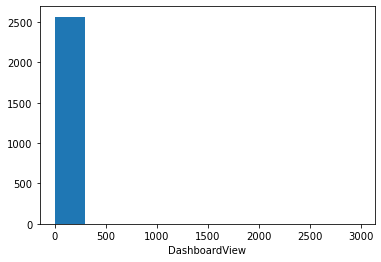

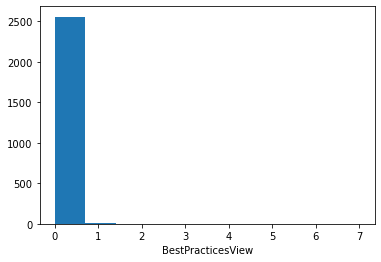

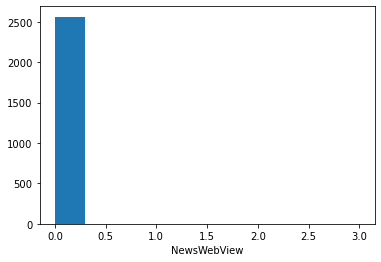

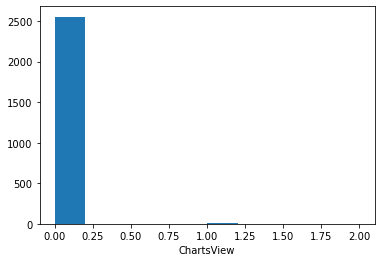

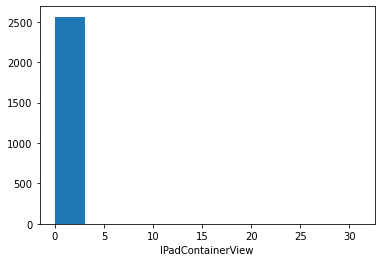

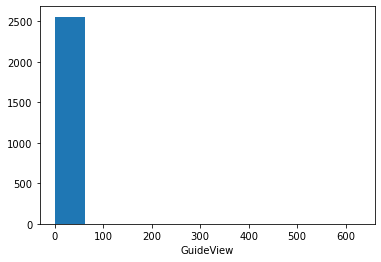

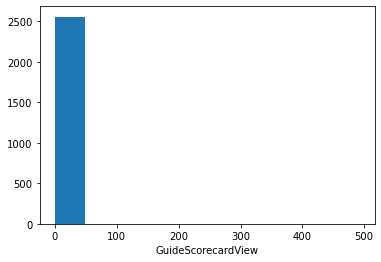

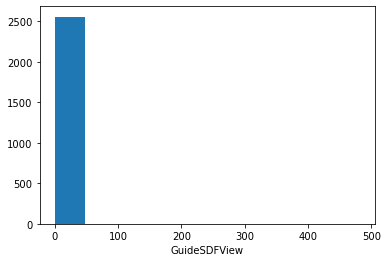

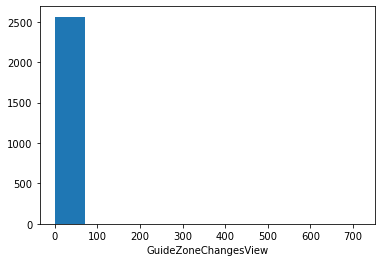

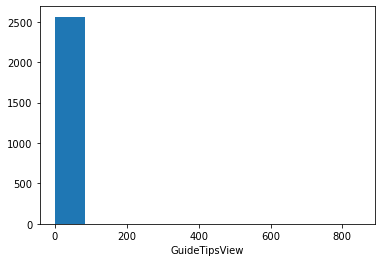

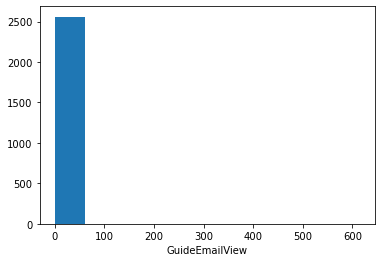

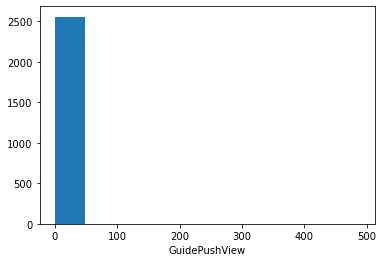

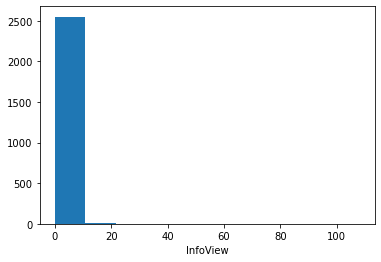

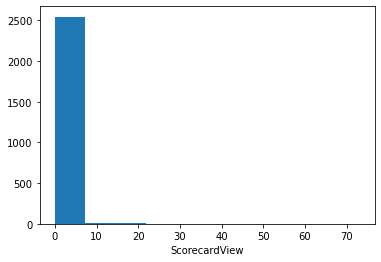

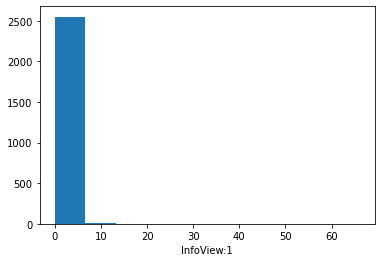

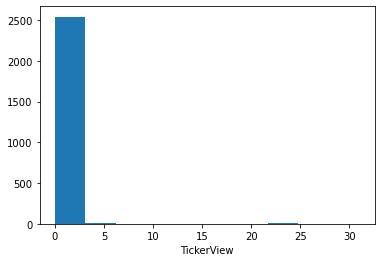

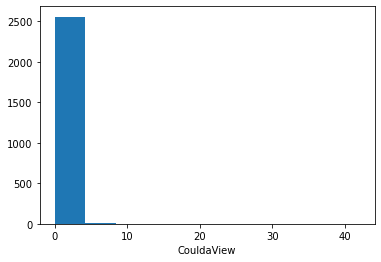

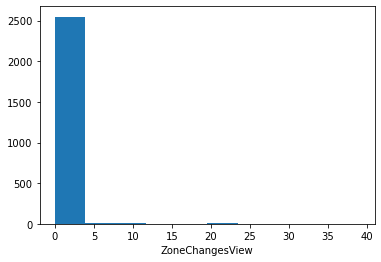

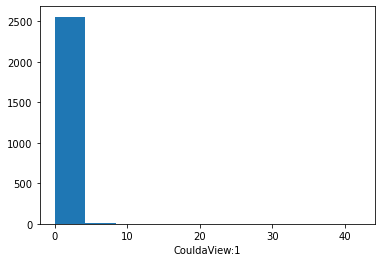

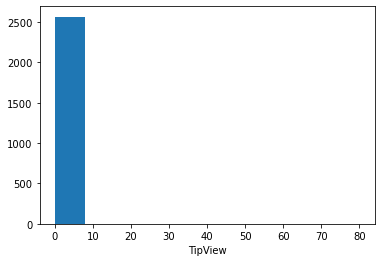

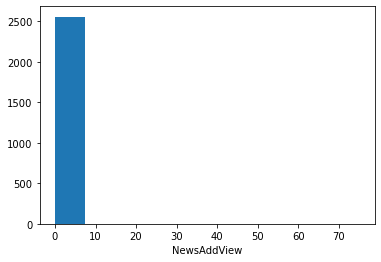

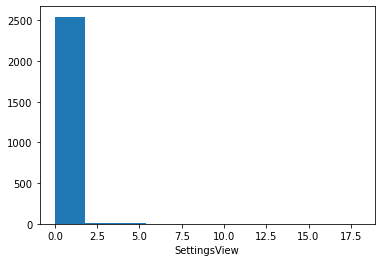

In [607]:
X = Time_per_view.drop('sec_length', axis= 1)

for i in X:
    plt.figure(i)
    plt.hist(X[i])
    plt.xlabel(i)
    #plt.savefig('sub30 {0}.jpg'.format(i))
    #plt.close()
    plt.show()

In [33]:
for col in X:
    print( col , ':', X[col].std(), "mean", ':', X[col].mean())

time_spent : 38.965467946730634 mean : 34.84615384615385
DashboardView : 4891.208022879106 mean : 2724.3846153846152
BestPracticesView : 29.79416566531622 mean : 12.23076923076923
NewsWebView : 4.898979485566356 mean : 2.0
TipsView : 139.6951809825364 mean : 61.92307692307692
ChartsView : 136.51730424738966 mean : 61.84615384615385
IPadContainerView : 54.74579951103615 mean : 24.46153846153846
GuideView : 1576.545220833622 mean : 669.0
GuideScorecardView : 1254.815432336871 mean : 364.53846153846155
GuideSDFView : 1166.0632816974717 mean : 336.9230769230769
GuideZoneChangesView : 1108.1259821462957 mean : 322.7692307692308
GuideTipsView : 1073.6565606637955 mean : 314.0769230769231
GuideEmailView : 1200.6493488834942 mean : 353.7692307692308
GuidePushView : 1008.9245607233327 mean : 296.53846153846155
InfoView : 932.354312534974 mean : 337.3076923076923
ScorecardView : 1440.0728213424593 mean : 623.6923076923077
InfoView:1 : 261.3314037082083 mean : 105.46153846153847
TickerView : 739.

In [18]:
subcribed_Time_per_view = """
    with t1 as(
        select *
        from new_df
        where lastSubscrib = 'Y'
    ),
    t2 as 
            (
            select 
                Sec_length
                , sum(case when view = 'DashboardViewController' then 1 else 0 
                    end) as DashboardView 
                , sum(case when view = 'BestPracticesViewController' then 1 else 0 
                    end) as BestPracticesView
                , sum(case when view = 'NewsWebViewController' then 1 else 0 
                    end) as NewsWebView
                , sum(case when view = 'TipsViewController' then 1 else 0 
                    end) as TipsView
                , sum(case when view = 'ChartsViewController' then 1 else 0 
                    end) as ChartsView       
                , sum(case when view = 'IPadContainerViewController' then 1 else 0 
                    end) as IPadContainerView  
                , sum(case when view = 'GuideViewController' then 1 else 0 
                    end) as GuideView
                , sum(case when view = 'GuideScorecardViewController' then 1 else 0 
                    end) as GuideScorecardView
                , sum(case when view = 'GuideSDFViewController' then 1 else 0 
                    end) as GuideSDFView
                , sum(case when view = 'GuideZoneChangesViewController' then 1 else 0 
                    end) as GuideZoneChangesView
                , sum(case when view = 'GuideTipsViewController' then 1 else 0 
                    end) as GuideTipsView
                , sum(case when view = 'GuideEmailViewController' then 1 else 0 
                    end) as GuideEmailView
                , sum(case when view = 'GuidePushViewController' then 1 else 0 
                    end) as GuidePushView
                , sum(case when view = 'InfoViewController' then 1 else 0 
                    end) as InfoView
                , sum(case when view = 'ScorecardViewController' then 1 else 0 
                    end) as ScorecardView
                , sum(case when view = 'NewsViewController' then 1 else 0 
                    end) as InfoView
                , sum(case when view = 'TickerViewController' then 1 else 0 
                    end) as TickerView
                , sum(case when view = 'CouldaViewController' then 1 else 0 
                    end) as CouldaView
                , sum(case when view = 'ZoneChangesViewController' then 1 else 0 
                    end) as ZoneChangesView
                , sum(case when view = 'CouldaViewController' then 1 else 0 
                    end) as CouldaView
                , sum(case when view = 'TipViewController' then 1 else 0 
                    end) as TipView
                , sum(case when view = 'NewsAddViewController' then 1 else 0 
                    end) as NewsAddView
                , sum(case when view = 'SettingsViewController' then 1 else 0 
                    end) as SettingsView
                , sum(case when view = 'IPadContainerViewController' then 1 else 0 
                    end) as IPadContainerView                 
            from t1
            group by 1
            )
        
    select 
        *
    from t2
    where Sec_length <= 30
    order by 2 desc
    
    """
subcribed_Time_per_view30 = sqldf(subcribed_Time_per_view)
subcribed_Time_per_view30

,Sec_length,DashboardView,BestPracticesView,NewsWebView,TipsView,ChartsView,IPadContainerView,GuideView,GuideScorecardView,GuideSDFView,...,ScorecardView,InfoView:1,TickerView,CouldaView,ZoneChangesView,CouldaView:1,TipView,NewsAddView,SettingsView,IPadContainerView:1
0,0.00,1283,4,6,331,151,26,499,64,60,...,859,245,119,140,206,140,885,314,32,26
1,2.31,702,4,0,6,31,0,114,171,162,...,861,29,268,27,163,27,30,45,15,0
2,1.16,616,7,1,3,30,15,197,66,138,...,475,11,177,20,105,20,50,88,6,15
3,3.47,492,1,0,21,36,1,68,130,93,...,555,23,235,45,159,45,26,26,23,1
4,4.63,347,2,0,21,29,3,96,102,83,...,349,32,192,40,119,40,26,21,31,3
5,5.79,302,1,0,19,32,2,55,67,64,...,241,33,150,29,94,29,33,32,20,2
6,6.94,274,1,0,15,31,1,62,66,55,...,173,17,113,29,78,29,27,18,18,1
7,8.10,241,0,1,9,29,1,42,28,25,...,132,16,92,26,80,26,27,23,22,1
8,9.26,207,1,0,9,25,0,34,30,35,...,106,20,78,20,54,20,31,14,21,0
9,10.42,191,0,0,14,15,1,16,22,15,...,112,16,64,22,48,22,21,13,19,1


In [19]:
unsubcribed_Time_per_view = """
    with t1 as(
        select *
        from new_df
        where lastSubscrib != 'Y'
    ),
    t2 as 
            (
            select 
                Sec_length
                , sum(case when view = 'DashboardViewController' then 1 else 0 
                    end) as DashboardView 
                , sum(case when view = 'BestPracticesViewController' then 1 else 0 
                    end) as BestPracticesView
                , sum(case when view = 'NewsWebViewController' then 1 else 0 
                    end) as NewsWebView
                , sum(case when view = 'TipsViewController' then 1 else 0 
                    end) as TipsView
                , sum(case when view = 'ChartsViewController' then 1 else 0 
                    end) as ChartsView       
                , sum(case when view = 'IPadContainerViewController' then 1 else 0 
                    end) as IPadContainerView  
                , sum(case when view = 'GuideViewController' then 1 else 0 
                    end) as GuideView
                , sum(case when view = 'GuideScorecardViewController' then 1 else 0 
                    end) as GuideScorecardView
                , sum(case when view = 'GuideSDFViewController' then 1 else 0 
                    end) as GuideSDFView
                , sum(case when view = 'GuideZoneChangesViewController' then 1 else 0 
                    end) as GuideZoneChangesView
                , sum(case when view = 'GuideTipsViewController' then 1 else 0 
                    end) as GuideTipsView
                , sum(case when view = 'GuideEmailViewController' then 1 else 0 
                    end) as GuideEmailView
                , sum(case when view = 'GuidePushViewController' then 1 else 0 
                    end) as GuidePushView
                , sum(case when view = 'InfoViewController' then 1 else 0 
                    end) as InfoView
                , sum(case when view = 'ScorecardViewController' then 1 else 0 
                    end) as ScorecardView
                , sum(case when view = 'NewsViewController' then 1 else 0 
                    end) as InfoView
                , sum(case when view = 'TickerViewController' then 1 else 0 
                    end) as TickerView
                , sum(case when view = 'CouldaViewController' then 1 else 0 
                    end) as CouldaView
                , sum(case when view = 'ZoneChangesViewController' then 1 else 0 
                    end) as ZoneChangesView
                , sum(case when view = 'CouldaViewController' then 1 else 0 
                    end) as CouldaView
                , sum(case when view = 'TipViewController' then 1 else 0 
                    end) as TipView
                , sum(case when view = 'NewsAddViewController' then 1 else 0 
                    end) as NewsAddView
                , sum(case when view = 'SettingsViewController' then 1 else 0 
                    end) as SettingsView
                , sum(case when view = 'IPadContainerViewController' then 1 else 0 
                    end) as IPadContainerView                 
            from t1
            group by 1
            )
        
    select 
        *
    from t2
    order by 2 desc
    
    """
unsubcribed_Time_per_view = sqldf(unsubcribed_Time_per_view)
unsubcribed_Time_per_view

,Sec_length,DashboardView,BestPracticesView,NewsWebView,TipsView,ChartsView,IPadContainerView,GuideView,GuideScorecardView,GuideSDFView,...,ScorecardView,InfoView:1,TickerView,CouldaView,ZoneChangesView,CouldaView:1,TipView,NewsAddView,SettingsView,IPadContainerView:1
0,0.00,4656,5,6,20,3,131,3288,74,71,...,64,102,24,31,50,31,426,311,22,131
1,1.16,1561,9,0,1,1,31,1091,184,385,...,27,27,14,16,8,16,47,217,4,31
2,2.31,1140,4,0,9,4,1,276,603,706,...,52,38,13,43,14,43,27,101,12,1
3,3.47,826,2,0,10,0,1,285,599,541,...,58,35,17,46,20,46,22,76,13,1
4,4.63,617,1,0,6,1,6,264,499,432,...,67,35,35,43,30,43,22,58,13,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6448,251586.81,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6449,309415.51,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
6450,382821.76,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6451,408168.98,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
usubcribed_Time_per_view = """
    with t1 as(
        select *
        from new_df
        where lastSubscrib != 'Y'
    ),
    t2 as 
            (
            select 
                Sec_length
                , sum(case when view = 'DashboardViewController' then 1 else 0 
                    end) as DashboardView 
                , sum(case when view = 'BestPracticesViewController' then 1 else 0 
                    end) as BestPracticesView
                , sum(case when view = 'NewsWebViewController' then 1 else 0 
                    end) as NewsWebView
                , sum(case when view = 'TipsViewController' then 1 else 0 
                    end) as TipsView
                , sum(case when view = 'ChartsViewController' then 1 else 0 
                    end) as ChartsView       
                , sum(case when view = 'IPadContainerViewController' then 1 else 0 
                    end) as IPadContainerView  
                , sum(case when view = 'GuideViewController' then 1 else 0 
                    end) as GuideView
                , sum(case when view = 'GuideScorecardViewController' then 1 else 0 
                    end) as GuideScorecardView
                , sum(case when view = 'GuideSDFViewController' then 1 else 0 
                    end) as GuideSDFView
                , sum(case when view = 'GuideZoneChangesViewController' then 1 else 0 
                    end) as GuideZoneChangesView
                , sum(case when view = 'GuideTipsViewController' then 1 else 0 
                    end) as GuideTipsView
                , sum(case when view = 'GuideEmailViewController' then 1 else 0 
                    end) as GuideEmailView
                , sum(case when view = 'GuidePushViewController' then 1 else 0 
                    end) as GuidePushView
                , sum(case when view = 'InfoViewController' then 1 else 0 
                    end) as InfoView
                , sum(case when view = 'ScorecardViewController' then 1 else 0 
                    end) as ScorecardView
                , sum(case when view = 'NewsViewController' then 1 else 0 
                    end) as InfoView
                , sum(case when view = 'TickerViewController' then 1 else 0 
                    end) as TickerView
                , sum(case when view = 'CouldaViewController' then 1 else 0 
                    end) as CouldaView
                , sum(case when view = 'ZoneChangesViewController' then 1 else 0 
                    end) as ZoneChangesView
                , sum(case when view = 'CouldaViewController' then 1 else 0 
                    end) as CouldaView
                , sum(case when view = 'TipViewController' then 1 else 0 
                    end) as TipView
                , sum(case when view = 'NewsAddViewController' then 1 else 0 
                    end) as NewsAddView
                , sum(case when view = 'SettingsViewController' then 1 else 0 
                    end) as SettingsView
                , sum(case when view = 'IPadContainerViewController' then 1 else 0 
                    end) as IPadContainerView                 
            from t1
            group by 1
            )
        
    select 
        *
    from t2
    where Sec_length <= 30
    order by 2 desc
    
    """
usubcribed_Time_per_view = sqldf(usubcribed_Time_per_view)
usubcribed_Time_per_view

,Sec_length,DashboardView,BestPracticesView,NewsWebView,TipsView,ChartsView,IPadContainerView,GuideView,GuideScorecardView,GuideSDFView,...,ScorecardView,InfoView:1,TickerView,CouldaView,ZoneChangesView,CouldaView:1,TipView,NewsAddView,SettingsView,IPadContainerView:1
0,0.00,4656,5,6,20,3,131,3288,74,71,...,64,102,24,31,50,31,426,311,22,131
1,1.16,1561,9,0,1,1,31,1091,184,385,...,27,27,14,16,8,16,47,217,4,31
2,2.31,1140,4,0,9,4,1,276,603,706,...,52,38,13,43,14,43,27,101,12,1
3,3.47,826,2,0,10,0,1,285,599,541,...,58,35,17,46,20,46,22,76,13,1
4,4.63,617,1,0,6,1,6,264,499,432,...,67,35,35,43,30,43,22,58,13,6
5,5.79,450,1,1,5,4,0,208,436,324,...,77,36,34,35,28,35,18,35,17,0
6,6.94,427,2,0,6,1,2,188,285,288,...,68,32,34,36,28,36,25,38,13,2
7,8.10,348,1,0,7,1,1,126,245,180,...,51,20,39,34,39,34,17,29,11,1
8,9.26,273,2,0,6,0,0,123,160,131,...,53,27,35,28,23,28,16,29,8,0
9,10.42,258,4,0,6,0,4,113,136,98,...,44,20,30,18,35,18,17,22,6,4


In [19]:
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

X = subcribed_Time_per_view30.drop('Sec_length', axis= 1)

for i in X:
    plt.figure(i)
    plt.hist(X[i])
    plt.xlabel(i)
    plt.savefig('sub30 {0}.jpg'.format(i))
    plt.close()

In [133]:
average_subcribed_ = sqldf("""
        select 
             avg(DashboardView) as avg_Dashboard
            , avg(BestPracticesView) as avg_BestPractices
            , avg(NewsWebView) as avg_NewsWeb
            , avg(TipsView) as avg_Tips
            , avg(ChartsView) as_charts
            , avg(IPadContainerView) as avg_IPaadcontainer
            , avg(GuideView) as avg_Guide
            , avg(GuideScorecardView) as avg_GuideScorecard
            , avg(GuideSDFView) as avg_GuideSDF
            , avg(GuideZoneChangesView) as avg_GuideZonechanges
            , avg(GuideTipsView) as avg_GuideTips
            , avg(GuideEmailView) as avg_GuideEmail
            , avg(GuidePushView) as avg_GuidePush
            , avg(InfoView) as avg_Info
            , avg(ScorecardView) as avg_Scorecard
            , avg(InfoView) as avg_Info
            , avg(TickerView) as avg_Ticker
        from subcribed_Time_per_view

""")

average_subcribed_Time_per_view

In [134]:
average_subcribed_Time_per_view

,avg_Dashboard,avg_BestPractices,avg_NewsWeb,avg_Tips,as_charts,avg_IPaadcontainer,avg_Guide,avg_GuideScorecard,avg_GuideSDF,avg_GuideZonechanges,avg_Guide,avg_GuideTips,avg_GuideEmail,avg_GuidePush,avg_Info,avg_Scorecard,avg_Info,avg_Ticker
0,49.99359,0.217949,0.044872,1.974359,2.451923,0.275641,5.121795,2.791667,2.564103,2.445513,5.121795,2.407051,2.724359,2.291667,8.772436,22.173077,8.772436,7.746795


In [154]:
X = subcribed_Time_per_view.drop('secCode', axis = 1)

import pandas as pd
for col in X:
    print( col , ':', X[col].std(), "mean", ':', X[col].mean())


DashboardView : 170.57954917114915 mean : 49.993589743589745
BestPracticesView : 0.9022649014261949 mean : 0.21794871794871795
NewsWebView : 0.492293650348011 mean : 0.04487179487179487
TipsView : 12.203498901538651 mean : 1.9743589743589745
ChartsView : 11.279449321544027 mean : 2.451923076923077
IPadContainerView : 0.9148557277275219 mean : 0.27564102564102566
GuideView : 6.582489632231128 mean : 5.121794871794871
GuideScorecardView : 4.40237378722962 mean : 2.7916666666666665
GuideSDFView : 4.377198280507134 mean : 2.5641025641025643
GuideZoneChangesView : 4.287525357493912 mean : 2.4455128205128207
GuideView:1 : 6.582489632231128 mean : 5.121794871794871
GuideTipsView : 4.21881579488697 mean : 2.407051282051282
GuideEmailView : 4.456396418760465 mean : 2.7243589743589745
GuidePushView : 4.0718855430463385 mean : 2.2916666666666665
InfoView : 22.56187226763232 mean : 8.772435897435898
ScorecardView : 118.15035728067188 mean : 22.173076923076923
InfoView:1 : 6.901184685985422 mean : 

In [7]:
#Average section length, total section length, maximum section length by each user
sqldf(""" 
    select 
        Distinct secCode
        , round(avg(Sec_length), 2) avg_ts
        , sum(Sec_length) sum_sec_len
        , max(Sec_length) max_sec
        , count(*) tot_count
    from new_df
    group by 1
    order by 5 Asc
    """)

,secCode,avg_ts,sum_sec_len,max_sec,tot_count
0,0076412A-A32E-4BAE-B9F5-4980A9C716F7,0.00,0.00,0.00,1
1,00B697C3-8B60-4522-B361-69F645FA3162,0.00,0.00,0.00,1
2,0C940233-98FF-4E7D-ABD5-A8BF5D514A68,0.00,0.00,0.00,1
3,0D6528A4-5852-4384-96EF-EDFD5042DAAC,0.00,0.00,0.00,1
4,0F35CA45-B59D-41B8-8E25-6BA2FC12E7B9,0.00,0.00,0.00,1
...,...,...,...,...,...
3807,F7EDDD3C-0B44-4CA0-85F0-5A35D739143C,6423.29,4387107.40,217880.79,683
3808,20D3791F-C179-46F6-A5E8-34D0ACC2C8DD,63250.57,50726954.83,12890190.97,802
3809,AB05BBE1-F3A3-43E3-B730-9CBDD069B048,45921.58,37196483.54,3519243.06,810
3810,0D034B75-58D4-4197-8F7B-6CC1F07A5661,6034.85,18726152.22,2367552.08,3103


In [ ]:
sqldf(""" 
    select 
        count(Distinct secCode)
    from (
        Select 
            Distinct secCode
            , count(*) tot_count
        from new_df
        group by 1
        having tot_count <= 10
        )
    """)

In [ ]:
#Average section length, total section length, maximum section length by each user
sqldf(""" 
   
   Select avg (avg_ts), avg(sum_sec_len), sum(sum_sec_len)
    from (
        Select 
            Distinct secCode
            , avg(Sec_length) avg_ts
            , sum(Sec_length) sum_sec_len
            , max(Sec_length) max_sec
            , count(*)
        from new_df
        group by secCode
        )
    
    """)

In [120]:
#tells number of times a page has been visited and averga time spent by users 
sqldf(""" 
    SELECT 
        view
        , action
        , count(*) total 
        , round(avg(Sec_length)) avg_sec_viewPerSec
    FROM new_df 
    group by view 
    order by 4 desc
""")

,view,action,total,avg_sec_viewPerSec
0,DashboardViewController,viewWillAppear,35417,408997.0
1,ZoneChangesViewController,viewWillAppear,3046,3025.0
2,ScorecardViewController,viewWillAppear,8108,2284.0
3,ChartsViewController,viewWillAppear,804,2235.0
4,TickerViewController,viewWillAppear,3314,1927.0
5,SettingsViewController,viewWillAppear,767,1835.0
6,CouldaViewController,viewWillAppear,1416,1203.0
7,TipViewController,tipRead,2494,677.0
8,SubscriptionViewController,viewWillAppear,3068,658.0
9,InfoViewController,viewWillAppear,4385,476.0


In [ ]:
sqldf("""
    SELECT 
        secCode
        , count(*)
    from new_df
    where secCode = '769539B9-0247-4E4F-9710-543D646E4984'
    group by 1  
    ORDER BY 2 Asc
""")

In [ ]:
sqldf(""" 
    Select view, avg(tot_time)
    from
    (
    SELECT 
        secCode, 
        view, 
        count(*),
        sum(ts_diff) tot_time
    FROM new_df
    group by 1,2
    ) t
    group by 1
    order 2 desc
""")

In [ ]:
sqldf(""" 
    SELECT 
        secCode
        , view
        , count(*) 
        , avg(Sec_length) avg_sec_length
        , sum(Sec_length) total_time
    FROM new_df
    group by 1,2
    order by 4  desc
    limit 20
""")

In [ ]:
sqldf( """ SELECT view, action, count(*) total, ts_diff
FROM new_df
WHERE  view = 'DashboardViewController'
group by 1,2
order by 3 desc
""")

In [ ]:
sqldf( """ SELECT view, action, count(*) total_counts, sum(Sec_length) avg_view_action
FROM new_df
WHERE  view = 'TipViewController'
group by 1,2
order by 3 desc
""")

In [ ]:
df.to_csv('df2.csv')

In [6]:
# All users by view by total_time spent on app
user_view = sqldf(""" 
    SELECT 
        secCode 
        , view 
        , count(*) Tot_view
        , sum(Sec_length) Tot_sec_len
        , avg(Sec_length) Avg_sec_len
    FROM new_df
    group by 1,2
    order by 5 Desc

""")

user_view

,secCode,view,Tot_view,Tot_sec_len,Avg_sec_len
0,769539B9-0247-4E4F-9710-543D646E4984,DashboardViewController,2,28116542.82,1.405827e+07
1,ACC86D38-7D43-40BB-87F4-8FE3EC6F739B,DashboardViewController,2,27738075.23,1.386904e+07
2,A7740EA6-BDD9-4419-8928-328AAA341A63,DashboardViewController,3,40611000.00,1.353700e+07
3,AA4331B3-CE5B-40AA-A2DE-75E57C6C432C,DashboardViewController,3,40038039.35,1.334601e+07
4,69D76D90-689A-4781-8CF4-48B6A0BC1B4F,DashboardViewController,2,24526413.19,1.226321e+07
...,...,...,...,...,...
31507,FF6D3C43-42EE-4A0C-9004-3B3E3F27D4B4,GuideViewController,1,0.00,0.000000e+00
31508,FFA909BE-0DA3-4923-95F7-82228EA6C33C,GuideViewController,1,0.00,0.000000e+00
31509,FFBCDFCF-1D90-4CBF-A5C4-0A350F2EFFED,IPadContainerViewController,1,0.00,0.000000e+00
31510,FFC18754-A253-47E5-AB2F-0D30255229EE,GuideViewController,1,0.00,0.000000e+00


In [ ]:
q = """Select secCode
        , timestamp
        , lag(timestamp) over (PARTITION by secCode order by timestamp asc) lag_ts
    from df 
    limit 30
    """

In [90]:
sqldf(q)

,secCode,activity_order,timestamp,start_time
0,0017241D-C63A-4248-9A8F-148AA30487BE,1,2020-12-30 12:20:28,2020-12-30 12:20:28
1,0017241D-C63A-4248-9A8F-148AA30487BE,2,2020-12-30 12:20:29,2020-12-30 12:20:28
2,0017241D-C63A-4248-9A8F-148AA30487BE,3,2020-12-30 12:20:32,2020-12-30 12:20:29
3,0017241D-C63A-4248-9A8F-148AA30487BE,4,2020-12-30 12:20:35,2020-12-30 12:20:32
4,0017241D-C63A-4248-9A8F-148AA30487BE,5,2020-12-30 12:20:38,2020-12-30 12:20:35
5,0017241D-C63A-4248-9A8F-148AA30487BE,6,2020-12-30 12:20:39,2020-12-30 12:20:38
6,0017241D-C63A-4248-9A8F-148AA30487BE,7,2020-12-30 12:20:41,2020-12-30 12:20:39
7,0017241D-C63A-4248-9A8F-148AA30487BE,8,2020-12-30 12:20:42,2020-12-30 12:20:41
8,0017241D-C63A-4248-9A8F-148AA30487BE,9,2020-12-30 12:20:44,2020-12-30 12:20:42
9,0017241D-C63A-4248-9A8F-148AA30487BE,10,2021-01-05 01:03:07,2020-12-30 12:20:44


In [89]:
q = """with t1 as (
    Select 
        secCode
        , timestamp
        , row_number() over (PARTITION by secCode order by timestamp asc) activity_order
        , lag(timestamp) over (PARTITION by secCode order by timestamp asc) lag_ts
    from df
)
select 
    secCode 
    , activity_order
    , timestamp
    , COALESCE(lag_ts, timestamp) start_time
from t1
limit 10
 """

In [ ]:
q = """
    Select *
        , COALESCE(lag(timestamp) over (PARTITION by secCode order by timestamp asc), timestamp) AS lag_ts
        , row_number() over (PARTITION by secCode order by timestamp asc) activity_order
    from df
 """